In [74]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import arviz as az
import warnings

from pathlib import Path
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.iolib.summary2 import summary_col

#%config InlineBackend.figure_format='svg'
warnings.filterwarnings("ignore", category=FutureWarning)

### Описание переменных и источников данных

Настоящее исследование построено на анализе данных, агрегированных на уровне политических партий. Ниже представлено описание всех переменных, использованных в регрессионных моделях.


* **Поддержка развертывания/вывода войск (support):** непрерывная переменная, отражающая долю членов парламентской фракции, поддержавших законопроект, санкционирующий начало или завершение участия национальных вооруженных сил (ВС) в конкретной международной операции; значения варьируются от 0 (полное отсутствие поддержки) до 1 (единогласная поддержка); [[Parliamentary Deployment Votes Database](http://deploymentvotewatch.eu)];
* **Идеология партии (lrgen/rile):** непрерывная переменная, измеряющая положение партии на шкале идеологического спектра «левые–правые»; значения нормированы в диапазон от 0 (крайне левые) до 10 (крайне правые); данные комбинируются из двух источников: [[Chapel Hill Expert Survey](https://www.chesdata.eu), [Manifesto Project Database](https://manifestoproject.wzb.eu)] для обеспечения робастности оценок;
* **Правительственный статус (gov):** дамми-переменная, принимающая значение 1, если партия входила в состав правящей коалиции на момент голосования, и 0 в противном случае; [[Parliamentary Deployment Votes Database](http://deploymentvotewatch.eu)];
* **Характер голосования (wthdr):** дамми-переменная, принимающая значение 1 для голосований, касающихся вывода войск (сворачивания операции), и 0 для голосований об их первоначальном развертывании [[Parliamentary Deployment Votes Database](http://deploymentvotewatch.eu)];
* **Институциональная рамка операции:** набор дамми-переменных, указывающих на организацию, под эгидой которой проводится операция; (1) операции под руководством НАТО или санкционированные Альянсом; (2) операции, санкционированные резолюцией Совета Безопасности ООН; (3) операции в рамках Общей политики безопасности и обороны (ОПБО) ЕС [на основании информации из открытых источников];
* **Тип операции:** набор дамми-переменных, классифицирующих миссию по ее основной цели и характеру ведения боевых действий: (1) операции с ясными гуманитарными целями, высокой международной легитимностью и низким непосредственным риском (гуманитарная помощь, ликвидация ЧС и пр.); (2) операции с кооперативным характером (военно-техническое сотрудничество, обучение, логистическая поддержка и пр.); (3) операции с высокой интенсивностью боевых действий и риском потерь (конвенциональная война, борьба с повстанцами) [на основании информации из открытых источников];
* **Союзнические обязательства (alliance):** дамми-переменная, отражающая членство страны в военном альянсе или двустороннем оборонительном соглашении [[Parliamentary Deployment Votes Database](http://deploymentvotewatch.eu)];
* **Концентрация власти в правительстве (herf):** индекс Херфиндаля-Хиршмана, рассчитанный на основе долей мест партий в правительственной коалиции; принимает значения от 0 до 1, где более высокие значения указывают на большую монополизацию власти внутри коалиции [[Database of Political Institutions 2020](https://data.iadb.org/dataset/the-database-of-political-institutions-dpi-2020)];
* **Электоральная поддержка партии (pervote):** доля голосов (в %), полученная партией на последних парламентских выборах, предшествовавших голосованию [[Manifesto Project Database](https://manifestoproject.wzb.eu)];
* **Историко-политический контекст (postcom):** дамми-переменная, принимающая значение 1 для стран, входивших в советский блок (посткоммунистические демократии), и 0 для остальных.

**Примечание по кодированию операций:** 

Ввиду различий в формулировках парламентских мандатов между странами, большинство операций были закодированы на агрегированном уровне — согласно официальным целям всей международной кампании. Для части миссий, однако, удалось выделить и закодировать специфические задачи, возложенные на контингент конкретной страны.

**Географическая и тематическая выборка:**

Анализ охватывает парламентские голосования в 21 стране-демократии: Австралия, Бельгия, Великобритания, Германия, Дания, Ирландия, Испания, Италия, Канада, Литва, Нидерланды, Республика Корея, Румыния, Словакия, США, Турция, Финляндия, Франция, Хорватия, Чешская Республика, Япония.

Полный список международных операций, включенных в анализ, доступен в [Parliamentary Deployment Votes Database](http://deploymentvotewatch.eu/wp-content/uploads/2021/07/PDVD_v3_list-of-missions.xlsx).

In [2]:
PROJECT_ROOT = Path().cwd().parent

df = pd.read_excel(PROJECT_ROOT.joinpath('data/final/votes.xlsx'))

df = df[[
    'country',
    'share_yes_votes',
    'lrgen',
    'rile',
    'gov_opp_num',
    'withdrawal_or_anti_interventionvote',
    'membership_alliance',
    'post_communist',
    'pervote',
    'herfgov',
    'un',
    'nato',
    'eu',
    'combat',
    'cooperative',
    'humanitarian'
]]

df = df.rename(columns={
    'share_yes_votes':'support',
    'gov_opp_num':'gov',
    'withdrawal_or_anti_interventionvote':'wthdr',
    'membership_alliance':'alliance',
    'post_communist':'postcom',
    'herfgov':'herf'
})

### Исследовательские гипотезы 

1. Институциональный статус партии (правящая/оппозиционная) модерирует взаимосвязь между ее идеологической позицией и поддержкой применения военной силы

2. Специфический характер военной операции (определяемый ее целями, уровнем риска, легитимностью и ожидаемыми издержками) модерирует взаимосвязь между идеологической позицией партии и ее поддержкой применения военной силы

### Эксплораторный анализ данных

#### MARPOR

In [3]:
marpor = df.drop(['lrgen'], axis=1)
marpor = marpor.dropna(ignore_index=True)
marpor['rile'] = np.interp(marpor['rile'], [-100, 100], [0, 10])

marpor.head(3)

country  support   rile  gov  wthdr  alliance  postcom  pervote  herf   un  \
0     AUL      0.0  4.150    0      0         1        0   11.255   1.0  1.0   
1     AUL      1.0  4.255    1      0         1        0   39.437   1.0  1.0   
2     AUL      1.0  6.360    0      0         1        0   34.758   1.0  1.0   

   nato   eu  combat  cooperative  humanitarian  
0   0.0  0.0     0.0          1.0           0.0  
1   0.0  0.0     0.0          1.0           0.0  
2   0.0  0.0     0.0          1.0           0.0

Единицей анализа в исследовании выступает **случай голосования политической партии по вопросу развертывания/сворачивания ВС** в рамках международной операции. Каждая запись в датафрейме репрезентирует отдельное парламентское голосование с указанием позиции конкретной политической партии.

Рассмотрим в качестве иллюстрации первую запись датафрейма, которая характеризуется следующими параметрами:

* Идеологическая позиция партии: левоцентристская *(rile ≈ 4)*
* Статус относительно правительственной коалиции: оппозиционная *(gov = 0)*
* Уровень поддержки: единогласное неодобрение *(support = 0)*
* Характер операции: кооперативный *(cooperative = 1)*

Содержательная интерпретация данной записи соответствует историческому случаю оспаривания партией "Австалийские демократы" участия в многонациональной операции в Персидском заливе в 1991 году. Кодировка операции как кооперативной основана на ограниченном характере военного участия Австралии, которое исключало ведение боевых действий и было сфокусировано на обеспечении морской блокады и медицинской поддержки в соответствии с мандатом многонациональных сил.

In [4]:
marpor.describe()

support         rile          gov        wthdr     alliance  \
count  4097.000000  4097.000000  4097.000000  4097.000000  4097.000000   
mean      0.658818     4.805196     0.363681     0.120088     0.930193   
std       0.451190     1.070155     0.481117     0.325104     0.254853   
min       0.000000     1.787550     0.000000     0.000000     0.000000   
25%       0.000000     4.020250     0.000000     0.000000     1.000000   
50%       0.982222     4.772500     0.000000     0.000000     1.000000   
75%       1.000000     5.485700     1.000000     0.000000     1.000000   
max       1.000000     8.000000     1.000000     1.000000     1.000000   

           postcom      pervote         herf           un         nato  \
count  4097.000000  4097.000000  4097.000000  4097.000000  4097.000000   
mean      0.200146    15.381025     0.640370     0.598731     0.427386   
std       0.400159    12.314824     0.237274     0.490215     0.494759   
min       0.000000     0.177000     0.184172     0.000000     0.000000   
25%       0.000000     5.989000     0.438437     0.000000     0.000000   
50%       0.000000    10.085000     0.555291     1.000000     0.000000   
75%       0.000000    25.180000     0.933413     1.000000     1.000000   
max       1.000000    53.691000     1.000000     1.000000     1.000000   

                eu       combat  cooperative  humanitarian  
count  4097.000000  4097.000000  4097.000000   4097.000000  
mean      0.132048     0.216012     0.525506      0.258482  
std       0.338584     0.411573     0.499410      0.437854  
min       0.000000     0.000000     0.000000      0.000000  
25%       0.000000     0.000000     0.000000      0.000000  
50%       0.000000     0.000000     1.000000      0.000000  
75%       0.000000     0.000000     1.000000      1.000000  
max       1.000000     1.000000     1.000000      1.000000

Анализ описательных статистик позволяет выявить общую тенденцию к поддержке политическими партиями внешнеполитических инициатив исполнительной власти, связанных с участием в международных операциях. Статистические показатели центральной тенденции подтверждают систематическое превышение уровня поддержки над нейтральным значением.

Квартильное распределение показателей поддержки демонстрирует высокую степень внутрипартийной консолидации при принятии решений о военном развертывании. Особенно показательным является минимальный межквартильный размах в верхних квартилях распределения, что свидетельствует о практически единогласной поддержке соответствующих инициатив значительной частью политических партий.

Полученные результаты согласуются с теоретическими ожиданиями, предполагающими высокий уровень партийной дисциплины при голосованиях по вопросам национальной безопасности и внешней политики. Данная закономерность может быть объяснена как действием формальных механизмов партийного контроля, так и существованием консенсуса по базовым вопросам внешнеполитического курса.

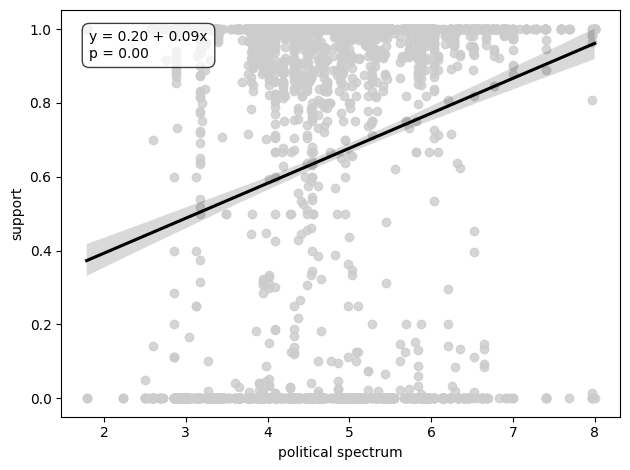

In [5]:
x = marpor['rile']
y = marpor['support']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

sns.regplot(x=x.rename('political spectrum'), 
            y=y, 
            color='.8', 
            line_kws=dict(color='black'))

stats_text = f'y = {intercept:.2f} + {slope:.2f}x\np = {p_value:.2f}'
plt.annotate(stats_text, 
             xy=(0.05, 0.95), 
             xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.75),
             fontsize=10,
             verticalalignment='top')

plt.tight_layout()
plt.show()

Визуальный анализ диаграммы рассеяния позволяет предварительно оценить характер взаимосвязи между идеологическими позициями политических партий и уровнем поддержки участия в международных операциях. Первичная визуализация предполагает наличие линейной положительной зависимости — партии, занимающие более правые позиции на идеологическом спектре, демонстрируют более высокий уровень поддержки внешнеполитических инициатив правительства.

Однако спецификация модели с квадратичным членом переменной идеологии выявляет нелинейный характер данной взаимосвязи. Потенциально это может свидетельствовать о том, что радикальные правые партии проявляют уровень поддержки, сопоставимый или даже более низкий по сравнению с правоцентристскими политическими силами. Этот криволинейный эффект позволяет предположить наличие определенного "порогового значения" на идеологическом спектре, за пределами которого дальнейшее смещение вправо не усиливает, а в некоторых случаях ослабляет поддержку международных операций.

Полученные результаты указывают на необходимость отказа от упрощенной линейной спецификации в пользу более сложных функциональных форм, учитывающих возможные нелинейные эффекты во взаимосвязи между идеологией и внешнеполитическими предпочтениями политических партий.

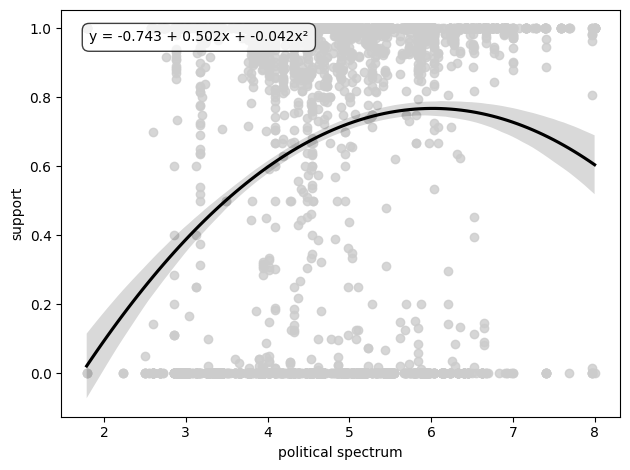

In [6]:
x = marpor['rile']
y = marpor['support']

coefficients = np.polyfit(x, y, 2)
poly = np.poly1d(coefficients)
y_pred = poly(x)

sns.regplot(x=x.rename('political spectrum'), 
            y=y, 
            color='.8', 
            line_kws=dict(color='black'),
            order=2)

stats_text = (f'y = {coefficients[2]:.3f} + {coefficients[1]:.3f}x + {coefficients[0]:.3f}x²')
plt.annotate(stats_text, 
             xy=(0.05, 0.95), 
             xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.75),
             fontsize=10,
             verticalalignment='top')

plt.tight_layout()
plt.show()

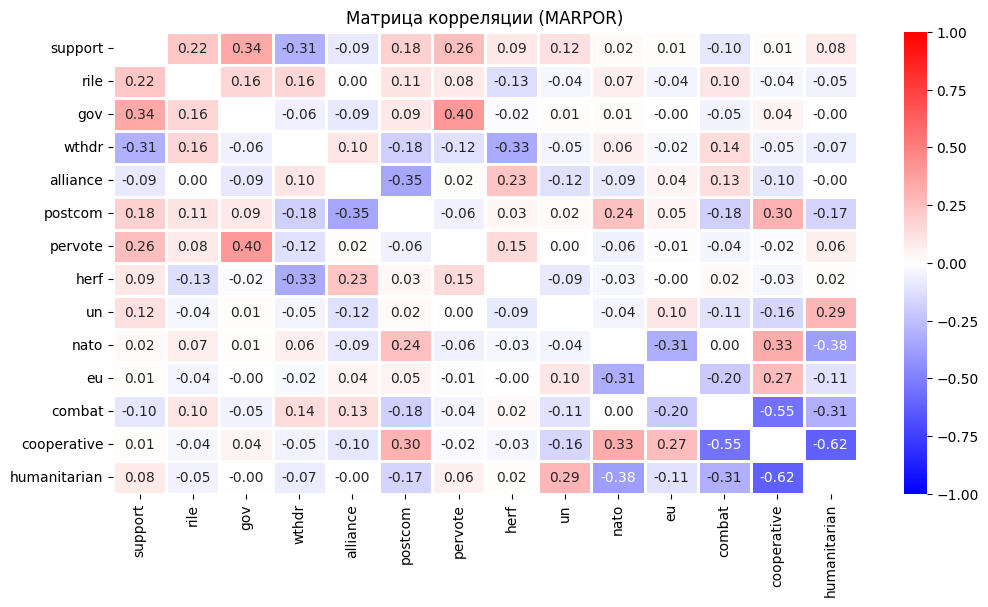

In [7]:
plt.figure(figsize=(12,6))
sns.heatmap(marpor.drop(columns='country').corr(), 
            vmin=-1, 
            vmax=1,
            annot=True, 
            linewidths=1, 
            fmt='.2f', 
            cmap='bwr', 
            mask=np.eye(marpor.drop(columns='country').corr().shape[0], dtype=bool)
            )

plt.title('Матрица корреляции (MARPOR)')
plt.savefig(PROJECT_ROOT.joinpath('figures/fig1'))

Результаты корреляционного анализа позволяют идентифицировать наиболее существенные предикторы поддержки решений о развертывании/сворачивании ВС в рамках международных операций. Наибольшая по величине связь с зависимой переменной наблюдается для предиктора, отражающего принадлежность политической партии к правительственной коалиции *(r = 0.34)*. Коэффициент корреляции Пирсона указывает на умеренную положительную связь, что подтверждает теоретическое предположение о более высокой лояльности правящих партий к внешнеполитическим инициативам правительства.

В отношении проблемы мультиколлинеарности следует отметить, что в корреляционной матрице отсутствуют коэффициенты, превышающие критическое значение *|r| > 0.7*, что позволяет предварительно исключить серьезную мультиколлинеарность между предикторами. Однако для окончательного вывода рекомендуется проведение дополнительного анализа с расчетом факторов инфляции дисперсии (VIF).

#### CHES

In [8]:
ches = df.drop('rile', axis=1)
ches = ches.dropna(ignore_index=True)

ches.describe()

support        lrgen          gov        wthdr     alliance  \
count  2848.000000  2848.000000  2848.000000  2848.000000  2848.000000   
mean      0.656844     4.947448     0.377809     0.153792     0.948736   
std       0.456303     2.273786     0.484925     0.360813     0.220575   
min       0.000000     0.600000     0.000000     0.000000     0.000000   
25%       0.000000     3.360000     0.000000     0.000000     1.000000   
50%       0.984536     5.111111     0.000000     0.000000     1.000000   
75%       1.000000     6.861607     1.000000     0.000000     1.000000   
max       1.000000     9.857142     1.000000     1.000000     1.000000   

           postcom      pervote         herf           un         nato  \
count  2848.000000  2848.000000  2848.000000  2848.000000  2848.000000   
mean      0.171348    14.332015     0.577844     0.593750     0.444874   
std       0.376879    11.258332     0.209185     0.491219     0.497039   
min       0.000000     0.591000     0.184172     0.000000     0.000000   
25%       0.000000     5.890000     0.435833     0.000000     0.000000   
50%       0.000000     9.654000     0.527408     1.000000     0.000000   
75%       0.000000    23.035000     0.674689     1.000000     1.000000   
max       1.000000    45.240000     1.000000     1.000000     1.000000   

                eu       combat  cooperative  humanitarian  
count  2848.000000  2848.000000  2848.000000   2848.000000  
mean      0.155899     0.243680     0.524930      0.231390  
std       0.362823     0.429377     0.499466      0.421795  
min       0.000000     0.000000     0.000000      0.000000  
25%       0.000000     0.000000     0.000000      0.000000  
50%       0.000000     0.000000     1.000000      0.000000  
75%       0.000000     0.000000     1.000000      0.000000  
max       1.000000     1.000000     1.000000      1.000000

Сравнительный анализ результатов, полученных на основе двух различных наборов данных, демонстрирует высокую степень консистентности оценок. Направление и статистическая значимость ключевых коэффициентов остаются устойчивыми, что свидетельствует о надежности выявленных закономерностей и их инвариантности к выбору конкретного источника данных.

Проведенный анализ усиливает валидность полученных выводов и позволяет с большей уверенностью утверждать, что выявленные эмпирические закономерности отражают реальные взаимосвязи, а не являются артефактом специфики используемого набора данных или метода измерения.

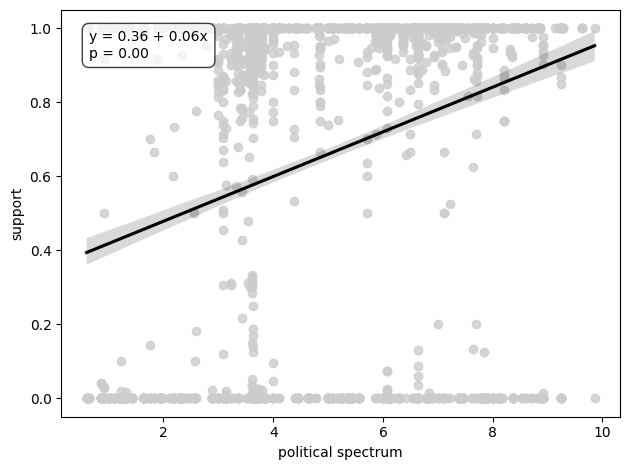

In [9]:
x = ches['lrgen']
y = ches['support']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

sns.regplot(x=x.rename('political spectrum'), 
            y=y, 
            color=".8", 
            line_kws=dict(color='black'))

stats_text = f'y = {intercept:.2f} + {slope:.2f}x\np = {p_value:.2f}'
plt.annotate(stats_text, 
             xy=(0.05, 0.95), 
             xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.75),
             fontsize=10,
             verticalalignment='top')

plt.tight_layout()
plt.show()

Визуальный анализ регрессионной зависимости демонстрирует четко выраженную криволинейную форму, напоминающую перевернутую подкову. Данная конфигурация указывает на то, что максимальная поддержка международных операций сосредоточена в центре идеологического спектра, тогда как крайне правые и крайне левые партии проявляют значительно меньший энтузиазм в отношении подобных инициатив.

Более того, усиление криволинейного характера взаимосвязи на данных Chapel Hill Expert Survey свидетельствует о том, что обнаруженный эффект не является артефактом конкретного метода измерения идеологии, а отражает фундаментальную закономерность политического поведения.

Полученные результаты не только подтверждают устойчивость первоначальных выводов, но и углубляют наше понимание нелинейной природы взаимосвязи, демонстрируя, что идеологическая позиция оказывает на внешнеполитические предпочтения более сложное и опосредованное влияние, чем предполагают традиционные линейные модели.

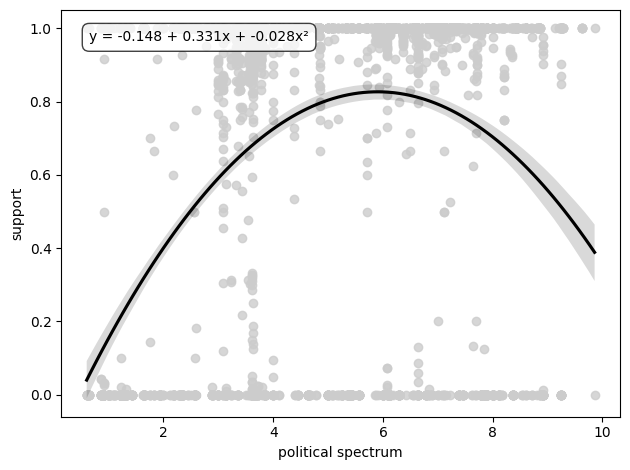

In [10]:
x = ches['lrgen']
y = ches['support']

coefficients = np.polyfit(x, y, 2)
poly = np.poly1d(coefficients)
y_pred = poly(x)

sns.regplot(x=x.rename('political spectrum'), 
            y=y, 
            color=".8", 
            line_kws=dict(color='black'),
            order=2)

stats_text = (f'y = {coefficients[2]:.3f} + {coefficients[1]:.3f}x + {coefficients[0]:.3f}x²')
plt.annotate(stats_text, 
             xy=(0.05, 0.95), 
             xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.75),
             fontsize=10,
             verticalalignment='top')

plt.tight_layout()
plt.show()

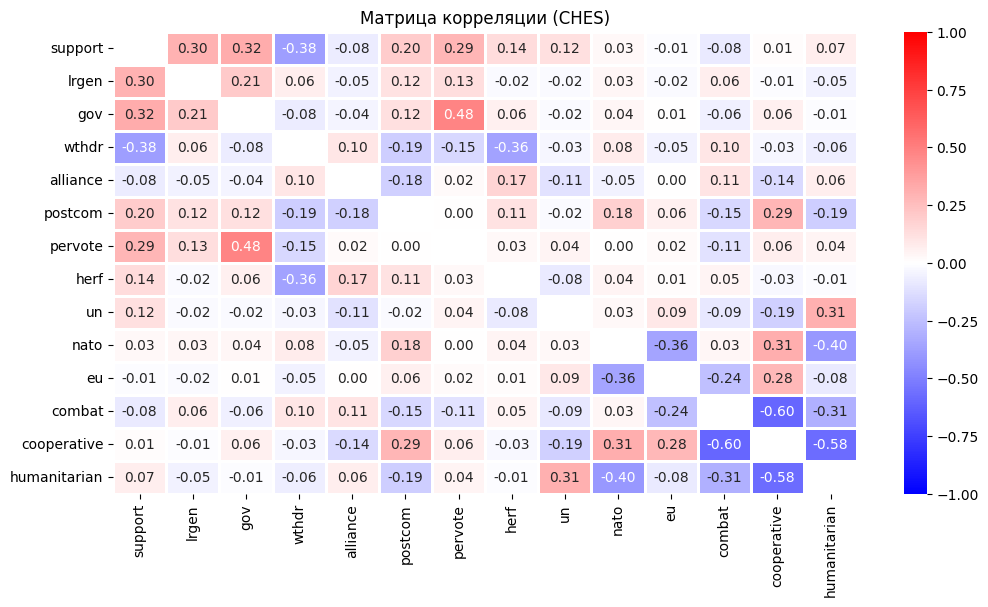

In [11]:
plt.figure(figsize=(12,6))
sns.heatmap(ches.drop(columns='country').corr(), 
            vmin=-1, 
            vmax=1,
            annot=True, 
            linewidths=1, 
            fmt='.2f', 
            cmap='bwr', 
            mask=np.eye(ches.drop(columns='country').corr().shape[0], dtype=bool)
            )

plt.title('Матрица корреляции (CHES)')
plt.savefig(PROJECT_ROOT.joinpath('figures/fig2'))

В отношении проблемы мультиколлинеарности следует отметить, что в корреляционной матрице отсутствуют коэффициенты, превышающие критическое значение *|r| > 0.7*, что позволяет предварительно исключить серьезную мультиколлинеарность между предикторами. Однако для окончательного вывода рекомендуется проведение дополнительного анализа с расчетом факторов инфляции дисперсии (VIF).

### Регрессионный анализ данных (Гипотеза 1)

Гипотеза 1 предполагает, что институциональный статус партии (правящая/оппозиционная) модерирует взаимосвязь между ее идеологической позицией и поддержкой применения военной силы.

Для проверки этой гипотезы мы включаем в модель переменную взаимодействия между идеологией партии и ее институциональным статусом: правительственная или оппозиционная партия. Такой подход позволяет оценить, изменяется ли сила и направление идеологического эффекта в зависимости от институционального статуса партии. Дополнительно мы включаем в модель квадратичный член идеологии для проверки предположения о нелинейном характере взаимосвязи.

#### Частотная статистика

Моделирование пропорциональной зависимой переменной на интервале [0;1] требует специализированных эконометрических подходов, поскольку применение стандартных методов наименьших квадратов (OLS) приводит к смещенным и несостоятельным оценкам.

В данном исследовании используются два альтернативных метода: Fractional Logit Regression (FLR) и Zero-One Inflated Beta Regression (ZOIB). Первая модель, предложенная [Papke & Wooldridge (1996)](https://econpapers.repec.org/article/jaejapmet/v_3a11_3ay_3a1996_3ai_3a6_3ap_3a619-32.html), представляет собой обобщенную линейную модель с логит-функцией связи и биномиальным распределением, адаптированную для работы с пропорциональными данными.

Интерпретация коэффициентов в FLR осуществляется через логарифмические шансы (log-odds), что требует экспоненцирования для преобразования в стандартные шансы (odds). Несмотря на некоторую сложность интерпретации, данный подход обеспечивает состоятельность оценок и соответствует природе анализируемых данных.

##### MARPOR

In [12]:
y = marpor['support']
X = marpor.drop(columns=['support','combat','cooperative','humanitarian','country'])
X = sm.add_constant(X)

m1 = sm.GLM(y, X, family=sm.families.Binomial())
m1 = m1.fit(cov_type='cluster',cov_kwds={'groups': marpor['country']})

print(m1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                support   No. Observations:                 4097
Model:                            GLM   Df Residuals:                     4086
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1967.0
Date:                Thu, 25 Dec 2025   Deviance:                       3514.4
Time:                        00:04:10   Pearson chi2:                 3.52e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2456
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.8180      1.166     -2.416      0.0

In [13]:
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

     Feature        VIF
0      const  47.182914
1       rile   1.098582
2        gov   1.245765
3      wthdr   1.241378
4   alliance   1.273666
5    postcom   1.330692
6    pervote   1.257892
7       herf   1.274059
8         un   1.035097
9       nato   1.218161
10        eu   1.150518


**Модель 1. Базовая спецификация**

Результаты базовой логит-модели демонстрируют умеренную объяснительную способность *(Pseudo R² = 0.246)* и указывают на наличие систематической взаимосвязи между идеологической позицией партий и их поддержкой применения военной силы.

Идеология оказывает статистически значимое положительное влияние на поддержку военных операций *($\beta$ = 0.509, p = 0.005)*: смещение партии вправо на идеологическом спектре ассоциируется с ростом логарифма шансов поддержки соответствующих решений. Данный результат соответствует классическим ожиданиям о большей склонности правых партий к поддержке использования военной силы.

Правительственный статус партии демонстрирует положительный, но лишь маргинально значимый эффект *($\beta$ = 1.350, p = 0.059)*, что указывает на тенденцию к более высокой поддержке операций со стороны партий, входящих в правящую коалицию, однако без однозначного статистического подтверждения в рамках данной спецификации.

Существенное влияние оказывает характер голосования: решения о выводе войск сопровождаются значительно более низким уровнем поддержки по сравнению с голосованиями о развертывании *($\beta$ = −2.108, p < 0.001)*. Это указывает на асимметрию парламентских предпочтений в отношении начала и завершения военных миссий.

Среди контрольных переменных статистически значимыми оказываются электоральная поддержка партии и наличие мандата Совета Безопасности ООН, что свидетельствует о важности как внутриполитических стимулов, так и международной легитимности операций. Остальные институциональные и контекстуальные факторы не демонстрируют самостоятельного эффекта в данной модели.

В целом базовая спецификация подтверждает наличие прямого идеологического эффекта, однако не позволяет оценить его условный характер. Это обосновывает необходимость последующего включения переменных взаимодействия и нелинейных компонентов для проверки гипотезы о модерирующей роли правительственного статуса и характеристик военных операций.

**Диагностика мультиколлинеарности**

Анализ факторов инфляции дисперсии (VIF) не выявляет признаков существенной мультиколлинеарности между независимыми переменными модели. Значения VIF для всех предикторов, за исключением константы, находятся в диапазоне от *1.03* до *1.33*, что значительно ниже общепринятых пороговых значений *(5 или 10)*.

Это указывает на низкую степень линейной зависимости между объясняющими переменными и позволяет считать оценки коэффициентов устойчивыми и интерпретируемыми.

In [14]:
marpor['rile2'] = marpor['rile']**2

y = marpor['support']
X = marpor.drop(columns=['support','combat','cooperative','humanitarian','country'])
X = sm.add_constant(X)

m2 = sm.GLM(y, X, family=sm.families.Binomial())
m2 = m2.fit(cov_type='cluster',cov_kwds={'groups': marpor['country']})

print(m2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                support   No. Observations:                 4097
Model:                            GLM   Df Residuals:                     4085
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1954.7
Date:                Thu, 25 Dec 2025   Deviance:                       3490.0
Time:                        00:04:10   Pearson chi2:                 3.46e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2500
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.7271      2.985     -1.919      0.0

**Модель 2. Спецификация с квадратичным членом**

Включение квадратичного члена идеологии приводит к умеренному улучшению объяснительной способности модели по сравнению с базовой спецификацией *(Pseudo R² = 0.250 против 0.246)*, что указывает на возможное наличие нелинейной взаимосвязи между идеологической позицией партии и поддержкой применения военной силы.

Линейный эффект идеологии остается положительным и маргинально значимым *($\beta$ = 1.772, p = 0.069)*, тогда как квадратичный член имеет отрицательный знак, хотя и не достигает стандартных уровней статистической значимости *($\beta$ = −0.131, p = 0.160)*. Совокупно данные коэффициенты указывают на вогнутую зависимость: по мере смещения партий вправо поддержка военных операций возрастает, однако данный эффект ослабевает на крайних значениях идеологического спектра.

Эффект правительственного статуса сохраняет положительное и маргинально значимое направление *($\beta$ = 1.303, p = 0.068)*, что свидетельствует о тенденции к более высокой поддержке операций со стороны правящих партий, независимо от их идеологической ориентации.

В целом модель указывает на ограниченную нелинейность идеологического эффекта, однако без учета институциональных взаимодействий данный подход не позволяет выявить условный характер идеологии, что обосновывает необходимость дальнейшего расширения спецификации в соответствии с первой исследовательской гипотезой.

In [15]:
scale = np.arange(0, 10.001, 0.001)
grid_data = pd.DataFrame({
    'const':1,
    'rile': scale,
    'gov': 1 if np.mean(marpor['gov']) > 0.5 else 0,
    'wthdr': 1 if np.mean(marpor['wthdr']) > 0.5 else 0,
    'alliance': 1 if np.mean(marpor['alliance']) > 0.5 else 0,
    'postcom': 1 if np.mean(marpor['postcom']) > 0.5 else 0,
    'pervote': np.mean(marpor['pervote']),
    'herf': np.mean(marpor['herf']),
    'un': 1 if np.mean(marpor['un']) > 0.5 else 0,
    'nato': 1 if np.mean(marpor['nato']) > 0.5 else 0,
    'eu': 1 if np.mean(marpor['eu']) > 0.5 else 0,
    'rile2': scale**2
})

predictions = m2.get_prediction(grid_data)
df_preds = pd.DataFrame({
    'rile': scale,
    'preds': predictions.predicted_mean,
    'conf_low': predictions.conf_int(alpha=0.05)[:,0],
    'conf_high': predictions.conf_int(alpha=0.05)[:,1]
})

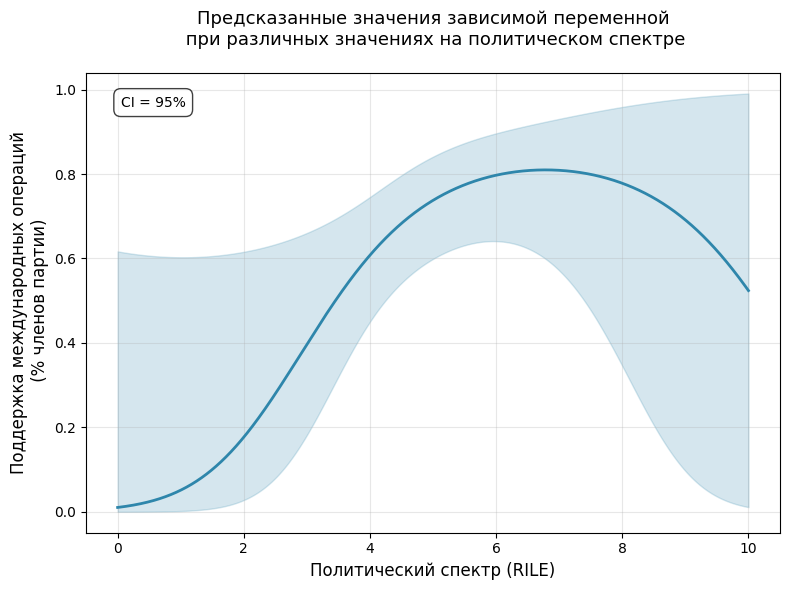

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.fill_between(x=df_preds['rile'], 
                 y1=df_preds['conf_low'], 
                 y2=df_preds['conf_high'],
                 alpha=0.2, 
                 color='#2E86AB')

plt.plot(df_preds['rile'], 
         df_preds['preds'], 
         linewidth=2, 
         color='#2E86AB')

ax.set_ylabel('Поддержка международных операций\n (% членов партии)', 
              fontsize=12)
ax.set_xlabel('Политический спектр (RILE)', fontsize=12)
ax.set_title('Предсказанные значения зависимой переменной\n при различных значениях на политическом спектре', 
             fontsize=13, pad=20)

plt.annotate(text='CI = 95%', 
             xy=(0.05, 0.95), 
             xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.75),
             fontsize=10,
             verticalalignment='top')

plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig(PROJECT_ROOT.joinpath('figures/fig3'))

**График предсказанных значений (Модель 2)**

Представленный график визуализирует нелинейную зависимость между идеологической позицией партии и предсказанной вероятностью поддержки международных военных операций, оцененную на основе Модели 2 при фиксированных значениях контрольных переменных.

Кривая предсказанных значений имеет вогнутую форму: по мере смещения от левых к центристским и умеренно правым позициям вероятность поддержки операций существенно возрастает, достигая максимума в правой части центра идеологического спектра. Однако при дальнейшем смещении к крайним правым позициям наблюдается снижение предсказанной поддержки. Данный паттерн согласуется с отрицательным знаком квадратичного члена идеологии в регрессионной модели.

Ширина 95%-го доверительного интервала увеличивается на крайних значениях шкалы, что указывает на меньшую эмпирическую определенность оценок для радикальных идеологических позиций и отражает ограниченное число наблюдений в этих диапазонах.

В целом график подтверждает выводы регрессионного анализа об ограниченной, но содержательно значимой нелинейности идеологического эффекта и показывает, что наибольшая поддержка применения военной силы характерна не для идеологических экстремумов, а для партий, занимающих умеренно правые позиции.

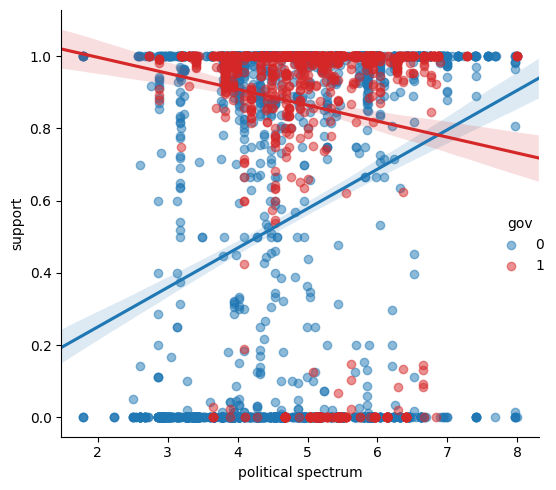

In [17]:
palette = sns.color_palette('tab10', 4)
custom_colors = [palette[0], palette[3]]

sns.lmplot(x ='rile', 
           y = 'support', 
           hue = 'gov', 
           data = marpor, 
           ci = 95, 
           palette=custom_colors,
           truncate=False,
           scatter_kws={'alpha': 0.5}
           ).set_axis_labels('political spectrum')

plt.tight_layout()
plt.show()

Представленный график иллюстрирует взаимосвязь между идеологической позицией партии и уровнем поддержки международных военных операций с раздельной визуализацией для оппозиционных и правительственных партий.

Для оппозиционных партий прослеживается выраженная положительная зависимость: по мере смещения вправо по идеологическому спектру уровень поддержки военных операций возрастает. Линейный тренд имеет отчетливо восходящий характер, что указывает на наличие систематического идеологического эффекта вне правительства.

В то же время для правительственных партий наблюдается иная конфигурация зависимости. Уровень поддержки в целом остется высоким по всему идеологическому спектру, а наклон линии тренда является слабым и даже отрицательным. Это указывает на существенное ослабление, а возможно и инверсию, идеологического эффекта среди партий, входящих в правящую коалицию.

Таким образом, график свидетельствует о том, что связь между идеологией и поддержкой применения военной силы носит условный характер и существенно различается в зависимости от институционального статуса партии. Данный визуальный паттерн обосновывает необходимость включения в регрессионную модель термина взаимодействия между идеологической позицией и правительственным статусом, реализованного в Модели 3.

In [18]:
marpor['rile_gov'] = marpor['rile'] * marpor['gov']

y = marpor['support']
X = marpor.drop(columns=['support','combat','cooperative','humanitarian','country','rile2'])
X = sm.add_constant(X)

m3 = sm.GLM(y, X, family=sm.families.Binomial())
m3 = m3.fit(cov_type='cluster',cov_kwds={'groups': marpor['country']})

print(m3.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                support   No. Observations:                 4097
Model:                            GLM   Df Residuals:                     4085
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1935.3
Date:                Thu, 25 Dec 2025   Deviance:                       3451.1
Time:                        00:04:10   Pearson chi2:                 3.51e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2571
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.4335      1.246     -2.756      0.0

**Модель 3. Спецификация с переменной взаимодействия**

Результаты логит-модели с включением взаимодействия между идеологической позицией партии и ее правительственным статусом демонстрируют небольшое улучшение объяснительной способности по сравнению с базовой спецификацией *(Pseudo R² = 0.257 против 0.246)* и подтверждают условный характер идеологического эффекта.

Идеология сохраняет положительное и статистически значимое влияние на поддержку применения военной силы *($\beta$ = 0.637, p = 0.001)*. Это означает, что среди оппозиционных партий смещение вправо по идеологическому спектру по-прежнему ассоциируется с ростом логарифма шансов поддержки военных операций.

Правительственный статус оказывает сильный положительный и статистически значимый эффект *($\beta$ = 5.413, p = 0.001)*, указывая на существенно более высокую поддержку соответствующих решений со стороны партий, входящих в правящую коалицию. Однако данный эффект следует интерпретировать с учетом включенного взаимодействия.

Коэффициент при переменной взаимодействия является отрицательным и статистически значимым *($\beta$ = −0.821, p = 0.013)*. Это свидетельствует о том, что участие партии в правительстве ослабляет положительную взаимосвязь между правой идеологической ориентацией и поддержкой применения военной силы. Иными словами, идеологические различия между левыми и правыми партиями выражены значительно сильнее в оппозиции, тогда как в правительстве они частично нивелируются.

В целом результаты модели подтверждают первую гипотезу исследования и указывают на модерирующую роль правительственного статуса во взаимосвязи между идеологией партии и ее позицией по вопросам применения военной силы.

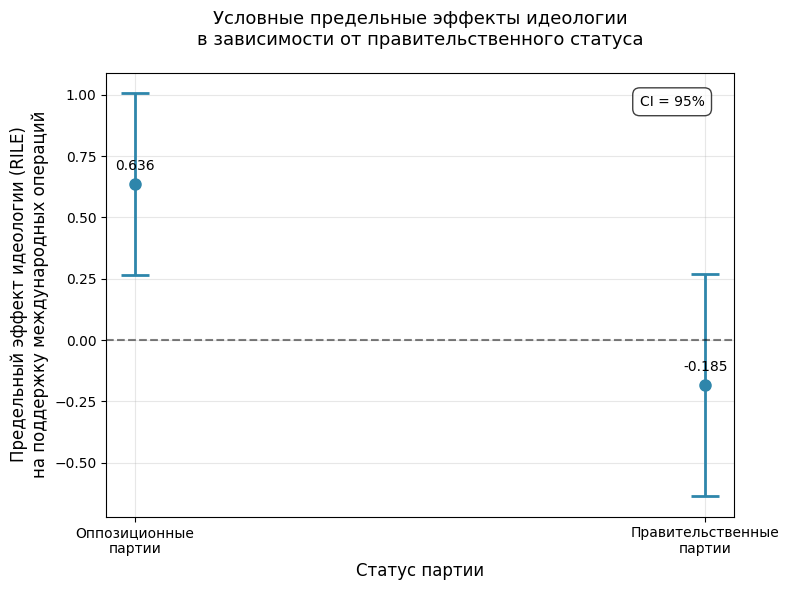

In [19]:
values = marpor.gov.unique()
marg_effect = m3.params[1] + m3.params[11]*values
Cov_m3 = np.asmatrix(m3.cov_params())
se = (Cov_m3[1,1] + values**2*(Cov_m3[11,11]) + 2*values*Cov_m3[1,11])**(.5)

fig, ax = plt.subplots(figsize=(8, 6))

plt.errorbar(values, marg_effect, yerr=stats.norm.ppf(0.975)*se, 
             fmt='o', markersize=8, capsize=10, capthick=2,
             color='#2E86AB', linewidth=2)

ax.set(xticks=[0,1], 
       xticklabels=['Оппозиционные\nпартии', 'Правительственные\nпартии'])
ax.set_ylabel('Предельный эффект идеологии (RILE)\nна поддержку международных операций', 
              fontsize=12)
ax.set_xlabel('Статус партии', fontsize=12)
ax.set_title('Условные предельные эффекты идеологии\nв зависимости от правительственного статуса', 
             fontsize=13, pad=20)

ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)

for i, (x, y) in enumerate(zip(values, marg_effect)):
    ax.annotate(f'{y:.3f}', (x, y), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=10)
    
plt.annotate(text='CI = 95%', 
             xy=(0.85, 0.95), 
             xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.75),
             fontsize=10,
             verticalalignment='top')

plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig(PROJECT_ROOT.joinpath('figures/fig4'))

**Условные предельные эффекты идеологии (Модель 3)**

Представленный график отображает условные предельные эффекты идеологической позиции партии на поддержку международных военных операций в зависимости от ее правительственного статуса, рассчитанные при фиксированных значениях контрольных переменных.

Для оппозиционных партий предельный эффект идеологии является положительным и статистически значимым: смещение партии вправо по идеологическому спектру ассоциируется с увеличением вероятности поддержки применения военной силы. 95%-й доверительный интервал полностью расположен выше нулевой линии, что указывает на устойчивость данного эффекта.

Напротив, для правительственных партий предельный эффект идеологии близок к нулю и статистически незначим: доверительный интервал пересекает нулевое значение, а точечная оценка имеет слабый отрицательный знак. Это свидетельствует об отсутствии систематической связи между идеологической позицией и поддержкой военных операций среди партий, входящих в правящую коалицию.

В целом график наглядно подтверждает результаты регрессионного анализа и указывает на выраженную асимметрию идеологического эффекта: идеология играет значимую роль в формировании позиций оппозиционных партий, тогда как для правительственных партий ее влияние существенно ослаблено или полностью нивелировано.

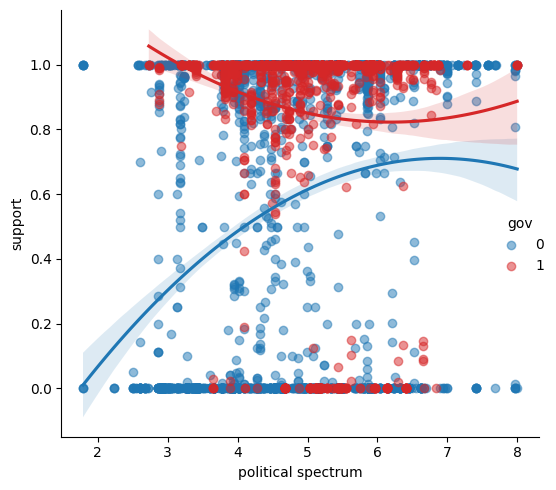

In [20]:
palette = sns.color_palette('tab10', 4)
custom_colors = [palette[0], palette[3]]

sns.lmplot(x ='rile', 
           y = 'support', 
           hue = 'gov', 
           data = marpor, 
           ci = 95, 
           order = 2,
           palette=custom_colors,
           scatter_kws={'alpha': 0.5}
           ).set_axis_labels('political spectrum')

plt.tight_layout()
plt.show()

Представленный график визуализирует зависимость между идеологической позицией партии и уровнем поддержки международных военных операций с раздельным отображением для оппозиционных и правительственных партий и учётом возможной нелинейности.

Для оппозиционных партий наблюдается отчетливо выраженная нелинейная зависимость: по мере смещения от левых к умеренно правым позициям уровень поддержки военных операций существенно возрастает, однако на крайних правых значениях шкалы рост замедляется и переходит в плато. Данный паттерн указывает на наличие вогнутой формы зависимости и свидетельствует о том, что максимальная поддержка характерна для умеренно правых оппозиционных партий, а не для идеологических экстремумов.

Для правительственных партий зависимость носит иной характер. Уровень поддержки в целом остается высоким по всему идеологическому спектру, а кривая имеет слабовыраженную *U*-образную форму с минимальными колебаниями. Это указывает на ослабление линейного идеологического эффекта и предполагает наличие более сложной, условной зависимости между идеологией и поддержкой военных операций внутри правящей коалиции.

Таким образом, график демонстрирует, что форма идеологического эффекта различается в зависимости от правительственного статуса партии и не может быть адекватно описана исключительно линейной спецификацией. Данный визуальный паттерн обосновывает необходимость включения в регрессионную модель квадратичных членов идеологии и их взаимодействий с правительственным статусом, реализованных в Модели 4.

In [21]:
marpor['rile2_gov'] = marpor['rile2'] * marpor['gov']

y = marpor['support']
X = marpor.drop(columns=['support','combat','cooperative','humanitarian','country'])
X = sm.add_constant(X)

m4 = sm.GLM(y, X, family=sm.families.Binomial())
m4 = m4.fit(cov_type='cluster',cov_kwds={'groups': marpor['country']})

print(m4.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                support   No. Observations:                 4097
Model:                            GLM   Df Residuals:                     4083
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1918.7
Date:                Thu, 25 Dec 2025   Deviance:                       3418.0
Time:                        00:04:10   Pearson chi2:                 3.46e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2631
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.7395      3.397     -1.984      0.0

**Модель 4. Спецификация с квадратичным членом и переменной взаимодействия**

Модель 4 расширяет предыдущую спецификацию за счет включения квадратичного члена идеологии и его взаимодействия с правительственным статусом, что позволяет оценить, различается ли не только сила, но и форма идеологического эффекта для правящих и оппозиционных партий. Объяснительная способность модели несколько возрастает *(Pseudo R² = 0.263)*.

Линейный эффект идеологии остается положительным, но лишь маргинально значимым *($\beta$ = 2.073, p = 0.065)*, тогда как квадратичный член не достигает статистической значимости. Это указывает на отсутствие устойчивой нелинейности идеологического эффекта среди оппозиционных партий, для которых зависимость между идеологией и поддержкой применения военной силы носит преимущественно линейный характер.

Правительственный статус сохраняет сильный положительный и статистически значимый эффект *($\beta$ = 14.723, p = 0.006)*, подтверждая существенно более высокий уровень поддержки военных операций со стороны партий, входящих в правящую коалицию.

Коэффициент при взаимодействии линейного идеологического члена с правительственным статусом является отрицательным и статистически значимым *($\beta$ = −4.639, p = 0.029)*, тогда как взаимодействие квадратичного члена — положительным и значимым *($\beta$ = 0.379, p = 0.046)*. В совокупности это указывает на то, что для правительственных партий идеологический эффект не только ослабляется, но и приобретает нелинейный характер, отличающийся от паттерна, наблюдаемого в оппозиции.

В целом результаты модели указывают на то, что взаимосвязь между идеологией и поддержкой применения военной силы является условной как по силе, так и по форме и существенно зависит от правительственного статуса партии, что дополнительно уточняет выводы, полученные в рамках Модели 3.

**Проверка устойчивости результатов**

Поскольку парламентские голосования в Германии и Италии составляют значительную долю исходной выборки, в моделях 5–8 они исключаются из анализа с целью проверки устойчивости основных эффектов и оценки того, не обусловлены ли полученные ранее результаты спецификой этих двух стран.

Модели 5–8 воспроизводят логическую структуру моделей 1–4 и оцениваются на сокращеной выборке *(N = 2806)*.

In [22]:
marpor_wo_ger_ita = marpor[~marpor['country'].isin(['ITA', 'GMY'])]

y = marpor_wo_ger_ita['support']
X = marpor_wo_ger_ita.drop(columns=['support','combat','cooperative','humanitarian','country','rile2','rile_gov','rile2_gov'])
X = sm.add_constant(X)

m1_add = sm.GLM(y, X, family=sm.families.Binomial())
m1_add = m1_add.fit(cov_type='cluster',cov_kwds={'groups': marpor_wo_ger_ita['country']})

y = marpor_wo_ger_ita['support']
X = marpor_wo_ger_ita.drop(columns=['support','combat','cooperative','humanitarian','country','rile_gov','rile2_gov'])
X = sm.add_constant(X)

m2_add = sm.GLM(y, X, family=sm.families.Binomial())
m2_add = m2_add.fit(cov_type='cluster',cov_kwds={'groups': marpor_wo_ger_ita['country']})

marpor['rile_gov'] = marpor['rile'] * marpor['gov']

y = marpor_wo_ger_ita['support']
X = marpor_wo_ger_ita.drop(columns=['support','combat','cooperative','humanitarian','country','rile2','rile2_gov'])
X = sm.add_constant(X)

m3_add = sm.GLM(y, X, family=sm.families.Binomial())
m3_add = m3_add.fit(cov_type='cluster',cov_kwds={'groups': marpor_wo_ger_ita['country']})

y = marpor_wo_ger_ita['support']
X = marpor_wo_ger_ita.drop(columns=['support','combat','cooperative','humanitarian','country'])
X = sm.add_constant(X)

m4_add = sm.GLM(y, X, family=sm.families.Binomial())
m4_add = m4_add.fit(cov_type='cluster',cov_kwds={'groups': marpor_wo_ger_ita['country']})

In [23]:
print(
    summary_col(
        [m1, m2, m3, m4, m1_add, m2_add, m3_add, m4_add],
        stars=True,
        model_names=['model 1', 'model 2', 'model 3', 'model 4', 'model 5', 'model 6', 'model 7', 'model 8'],
        info_dict={
            'N': lambda x: '{0:d}'.format(int(x.nobs)),
            'LLF': lambda x: '{:.3f}'.format(x.llf),
            'Pseudo R2': lambda x: '{:.3f}'.format(1 - (x.llf / x.llnull)),
            'AIC': lambda x: '{:.1f}'.format(x.aic),
        },
        regressor_order=[
            'const',
            'rile',
            'rile2', 
            'gov',
            'rile_gov',
            'rile2_gov',
            'wthdr',
            'alliance',
            'postcom',
            'pervote',
            'herf',
            'un',
            'nato',
            'eu'
        ],
        float_format='%.3f'
    )
)
print("""
All models include cluster-robust standard errors.

Models 5-8 are based on a limited sample (without GER & ITA parties)  
""")


           model 1   model 2   model 3   model 4   model 5   model 6   model 7   model 8 
-----------------------------------------------------------------------------------------
const     -2.818**  -5.727*   -3.434*** -6.740**  -2.065*   -3.880*   -2.780**  -4.686** 
          (1.166)   (2.985)   (1.246)   (3.397)   (1.135)   (2.175)   (1.103)   (2.387)  
rile      0.509***  1.771*    0.636***  2.073*    0.419*    1.229*    0.570***  1.426*   
          (0.183)   (0.973)   (0.190)   (1.123)   (0.215)   (0.717)   (0.200)   (0.826)  
rile2               -0.131              -0.150              -0.085              -0.093   
                    (0.093)             (0.107)             (0.071)             (0.085)  
gov       1.350*    1.303*    5.413***  14.723*** 0.798     0.772     5.450***  19.536***
          (0.716)   (0.714)   (1.617)   (5.374)   (0.738)   (0.738)   (1.354)   (5.194)  
rile_gov                      -0.821**  -4.639**                      -0.935*** -6.482***
         

**Интерпретация результатов**

Результаты анализа демонстрируют высокую устойчивость основных выводов. В базовых спецификациях (модели 5 и 7) идеологическая позиция партии сохраняет положительный и статистически значимый эффект, что подтверждает наличие прямой связи между смещением вправо по идеологическому спектру и поддержкой применения военной силы и за пределами крупнейших (по количеству наблюдений) стран выборки.

В модели 7 коэффициент при переменной взаимодействия остается отрицательным и статистически значимым *($\beta$ = −1.115, p < 0.01)*, что указывает на сохранение модерирующей роли правительственного статуса. Как и в полной выборке, идеологический эффект выражен значительно сильнее среди оппозиционных партий и ослабевает для партий, входящих в правящую коалицию.

Модель 8, включающая квадратичный член идеологии и его взаимодействие с правительственным статусом, воспроизводит ранее выявленный паттерн: линейное взаимодействие имеет отрицательный и статистически значимый эффект, тогда как взаимодействие квадратичного члена — положительный и значимый *($\beta$ = 0.435, p < 0.05)*. Это указывает на устойчивые различия не только в силе, но и в форме идеологического эффекта между правительственными и оппозиционными партиями.

В целом исключение Германии и Италии не приводит к качественному пересмотру результатов. Основные выводы о условном характере идеологического эффекта и ключевой роли правительственного статуса оказываются устойчивыми и не зависят от структуры выборки по странам.

##### CHES

In [24]:
y = ches['support']
X = ches.drop(columns=['support','combat','cooperative','humanitarian','country'])
X = sm.add_constant(X)

m5 = sm.GLM(y, X, family=sm.families.Binomial())
m5 = m5.fit(cov_type='cluster',cov_kwds={'groups': ches['country']})

print(m5.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                support   No. Observations:                 2848
Model:                            GLM   Df Residuals:                     2837
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1298.3
Date:                Thu, 25 Dec 2025   Deviance:                       2349.7
Time:                        00:04:10   Pearson chi2:                 2.93e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2887
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6845      0.961     -1.753      0.0

In [25]:
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

     Feature        VIF
0      const  36.102042
1      lrgen   1.069757
2        gov   1.369225
3      wthdr   1.285473
4   alliance   1.116334
5    postcom   1.168155
6    pervote   1.355804
7       herf   1.239512
8         un   1.038550
9       nato   1.230968
10        eu   1.182145


**Модель 1.2. Базовая спецификация**

Представленная модель воспроизводит базовую спецификацию модели 1, однако идеологическая позиция партии измеряется с использованием данных *Chapel Hill Expert Survey (lrgen)*, а анализ проводится на альтернативной выборке (N = 2848). Это позволяет оценить устойчивость полученных ранее результатов к изменению источника измерения идеологии.

Результаты модели в целом согласуются с выводами, полученными на основе данных *Manifesto Project*. Идеология оказывает положительное влияние на поддержку применения военной силы, однако эффект является лишь маргинально значимым *($\beta$ = 0.295, p = 0.066)* и по величине заметно слабее, чем в базовой модели с использованием показателя *rile*. Это указывает на то, что связь между правой идеологической ориентацией и поддержкой военных операций воспроизводится, но оказывается менее выраженной.

Правительственный статус партии не демонстрирует статистически значимого эффекта, что также отличает данную спецификацию от базовой модели 1, где данный коэффициент был по крайней мере маргинально значимым. Это может отражать меньшую чувствительность идеологической шкалы к институциональным различиям между партиями или особенности сокращенной выборки.

Контрольные переменные в значительной степени воспроизводят ранее выявленные закономерности. Голосования о выводе войск сопровождаются существенно более низкой поддержкой *($\beta$ = −2.343, p = 0.002)*, а наличие мандата Совета Безопасности ООН остается одним из наиболее сильных и устойчивых предикторов поддержки военных операций. Электоральная поддержка партии также сохраняет положительный и статистически значимый эффект.

В целом результаты модели свидетельствуют о содержательной сопоставимости выводов, полученных на основе различных источников данных об идеологии. Несмотря на ослабление силы и статистической значимости идеологического эффекта при использовании CHES, его направление и ключевые контрольные зависимости остаются стабильными, что повышает доверие к основным выводам исследования.

**Диагностика мультиколлинеарности**

Анализ факторов инфляции дисперсии (VIF) не выявляет признаков существенной мультиколлинеарности между объясняющими переменными. Значения VIF для всех предикторов, за исключением константы, находятся в узком диапазоне от *1.04* до *1.37*, что значительно ниже общепринятых пороговых значений *(5 или 10)*.

В целом результаты диагностики указывают на низкую степень линейной зависимости между ковариатами и позволяют считать оценки коэффициентов в модели устойчивыми. Это означает, что ослабление идеологического эффекта при использовании *lrgen* не является следствием мультиколлинеарности и, вероятнее всего, отражает различия в источниках и способах измерения партийной идеологии.

In [26]:
ches['lrgen2'] = ches['lrgen']**2

y = ches['support']
X = ches.drop(columns=['support','combat','cooperative','humanitarian','country'])
X = sm.add_constant(X)

m6 = sm.GLM(y, X, family=sm.families.Binomial())
m6 = m6.fit(cov_type='cluster',cov_kwds={'groups': ches['country']})

print(m6.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                support   No. Observations:                 2848
Model:                            GLM   Df Residuals:                     2836
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1238.9
Date:                Thu, 25 Dec 2025   Deviance:                       2230.9
Time:                        00:04:10   Pearson chi2:                 3.09e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3177
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5073      1.893     -1.853      0.0

**Модель 2.2. Спецификация с квадратичным членом**

Включение квадратичного члена идеологии приводит к умеренному улучшению объяснительной способности модели по сравнению с базовой спецификацией *(Pseudo R² = 0.324 против 0.289)*, что указывает на возможное наличие нелинейной взаимосвязи между идеологической позицией партии и поддержкой применения военной силы.

Результаты модели в целом подтверждают ключевые выводы, полученные на основе данных *MARPOR*. Идеология оказывает положительное влияние на поддержку применения военной силы, однако эффект остается лишь маргинально значимым *($\beta$ = 1.31, p = 0.074)*. Направление эффекта совпадает с моделью 2, но величина и уровень значимости немного ниже, что указывает на ослабление силы связи между правой ориентацией партии и поддержкой военных операций при использовании *CHES*. Квадратичный компонент идеологии также демонстрирует слабый отрицательный эффект, близкий к значимости, что согласуется с гипотезой о нелинейности идеологического влияния.

Правительственный статус партии не проявляет статистически значимого эффекта, в отличие от базовой модели, где он был хотя бы маргинально значим. Это может отражать меньшую чувствительность шкалы к институциональным особенностям партий или влияние особенностей альтернативной выборки.

Таким образом, несмотря на ослабление идеологического влияния, результаты модели демонстрируют высокую степень согласованности с моделью 2. Направления эффектов и ключевые контрольные зависимости остаются стабильными, что укрепляет доверие к основным выводам исследования о детерминантах поддержки военных операций.

In [27]:
scale = np.arange(0, 10.001, 0.001)
grid_data = pd.DataFrame({
    'const':1,
    'lrgen': scale,
    'gov': 1 if np.mean(ches['gov']) > 0.5 else 0,
    'wthdr': 1 if np.mean(ches['wthdr']) > 0.5 else 0,
    'alliance': 1 if np.mean(ches['alliance']) > 0.5 else 0,
    'postcom': 1 if np.mean(ches['postcom']) > 0.5 else 0,
    'pervote': np.mean(ches['pervote']),
    'herf': np.mean(ches['herf']),
    'un': 1 if np.mean(ches['un']) > 0.5 else 0,
    'nato': 1 if np.mean(ches['nato']) > 0.5 else 0,
    'eu': 1 if np.mean(ches['eu']) > 0.5 else 0,
    'lrgen2': scale**2
})

predictions = m6.get_prediction(grid_data)
df_preds = pd.DataFrame({
    'lrgen': scale,
    'preds': predictions.predicted_mean,
    'conf_low': predictions.conf_int(alpha=0.05)[:,0],
    'conf_high': predictions.conf_int(alpha=0.05)[:,1]
})

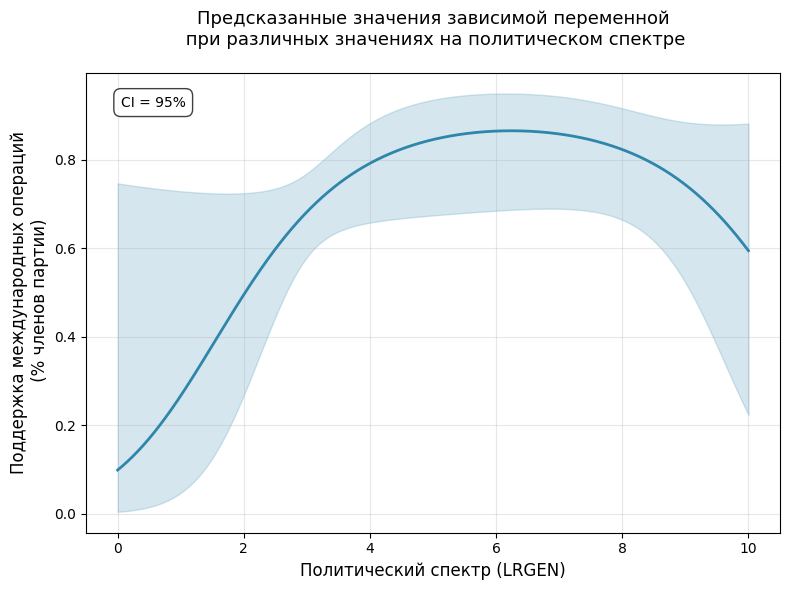

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.fill_between(x=df_preds['lrgen'], 
                 y1=df_preds['conf_low'], 
                 y2=df_preds['conf_high'],
                 alpha=0.2, 
                 color='#2E86AB')

plt.plot(df_preds['lrgen'], 
         df_preds['preds'], 
         linewidth=2, 
         color='#2E86AB')

ax.set_ylabel('Поддержка международных операций\n (% членов партии)', 
              fontsize=12)
ax.set_xlabel('Политический спектр (LRGEN)', fontsize=12)
ax.set_title('Предсказанные значения зависимой переменной\n при различных значениях на политическом спектре', 
             fontsize=13, pad=20)

plt.annotate(text='CI = 95%', 
             xy=(0.05, 0.95), 
             xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.75),
             fontsize=10,
             verticalalignment='top')

plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig(PROJECT_ROOT.joinpath('figures/fig5'))

**График предсказанных значений (Модель 2.2)**

Представленный график визуализирует нелинейную зависимость между идеологической позицией партии и предсказанной вероятностью поддержки международных военных операций, оцененную на основе Модели 2.2 при фиксированных значениях контрольных переменных.

Кривая предсказанных значений имеет вогнутую форму: по мере смещения от левых к центристским и умеренно правым позициям вероятность поддержки операций существенно возрастает, достигая максимума в правой части центра идеологического спектра. Однако при дальнейшем смещении к крайним правым позициям наблюдается снижение предсказанной поддержки. Данный паттерн согласуется с отрицательным знаком квадратичного члена идеологии в регрессионной модели.

Ширина 95%-го доверительного интервала значительно увеличивается на крайних значениях шкалы, что указывает на меньшую эмпирическую определенность оценок для радикальных идеологических позиций и отражает ограниченное число наблюдений в этих диапазонах.

В целом график подтверждает выводы регрессионного анализа об ограниченной, но содержательно значимой нелинейности идеологического эффекта и показывает, что наибольшая поддержка применения военной силы характерна не для идеологических экстремумов, а для партий, занимающих умеренно правые позиции.

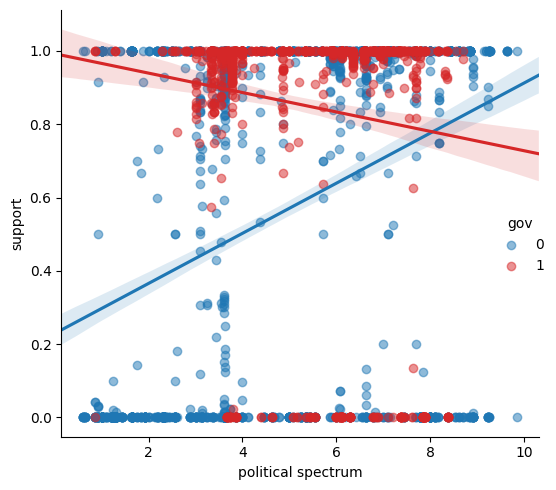

In [29]:
palette = sns.color_palette('tab10', 4)
custom_colors = [palette[0], palette[3]]

sns.lmplot(x ='lrgen', 
           y = 'support', 
           hue = 'gov', 
           data = ches, 
           ci = 95, 
           palette=custom_colors,
           truncate=False,
           scatter_kws={'alpha': 0.5}
           ).set_axis_labels('political spectrum')

plt.tight_layout()
plt.show()

Представленный график иллюстрирует взаимосвязь между идеологической позицией партии и уровнем поддержки международных военных операций с раздельной визуализацией для оппозиционных и правительственных партий.

Для оппозиционных партий прослеживается выраженная положительная зависимость: по мере смещения вправо по идеологическому спектру уровень поддержки военных операций возрастает. Линейный тренд имеет отчетливо восходящий характер, что указывает на наличие систематического идеологического эффекта вне правительства.

В то же время для правительственных партий наблюдается иная конфигурация зависимости. Уровень поддержки в целом остется высоким по всему идеологическому спектру, а наклон линии тренда является слабым и даже отрицательным. Это указывает на существенное ослабление, а возможно и инверсию, идеологического эффекта среди партий, входящих в правящую коалицию.

Таким образом, график свидетельствует о том, что связь между идеологией и поддержкой применения военной силы носит условный характер и существенно различается в зависимости от институционального статуса партии. Данный визуальный паттерн обосновывает необходимость включения в регрессионную модель термина взаимодействия между идеологической позицией и правительственным статусом, реализованного в Модели 3.

In [30]:
ches['lrgen_gov'] = ches['lrgen'] * ches['gov']

y = ches['support']
X = ches.drop(columns=['support','combat','cooperative','humanitarian','country','lrgen2'])
X = sm.add_constant(X)

m7 = sm.GLM(y, X, family=sm.families.Binomial())
m7 = m7.fit(cov_type='cluster',cov_kwds={'groups': ches['country']})

print(m7.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                support   No. Observations:                 2848
Model:                            GLM   Df Residuals:                     2836
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1274.1
Date:                Thu, 25 Dec 2025   Deviance:                       2301.4
Time:                        00:04:11   Pearson chi2:                 2.99e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3006
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8267      0.926     -1.973      0.0

**Модель 3.2. Спецификация с переменной взаимодействия**

Результаты логит-модели с включением взаимодействия между идеологической позицией партии и ее правительственным статусом демонстрируют небольшое улучшение объяснительной способности по сравнению с базовой спецификацией *(Pseudo R² = 0.301 против 0.289)* и подтверждают условный характер идеологического эффекта. В целом, результаты демонстрируют устойчивость основных закономерностей, выявленных в предыдущих спецификациях, при этом уточняется роль идеологии в контексте правительственного положения.

Идеология сохраняет положительное и теперь статистически значимое влияние на поддержку развертывания ВС в рамках международных операций *($\beta$ = 0.353, p = 0.025)*. Это означает, что среди оппозиционных партий смещение вправо по идеологическому спектру по-прежнему ассоциируется с ростом логарифма шансов поддержки военных операций.

Правительственный статус партии также положителен и статистически значим *($\beta$ = 3.369, p = 0.008)*, указывая на существенно более высокую поддержку соответствующих решений со стороны партий, входящих в правящую коалицию. Однако данный эффект следует интерпретировать с учетом включенного взаимодействия.

Коэффициент при переменной взаимодействия является отрицательным и статистически значимым *($\beta$ = −0.429, p = 0.001)*. Это свидетельствует о том, что участие партии в правительстве ослабляет положительную взаимосвязь между правой идеологической ориентацией и поддержкой решения об участии национальных вооруженных сил в международной операции. Иными словами, идеологические различия между левыми и правыми партиями выражены значительно сильнее в оппозиции, тогда как в правительстве они частично нивелируются.

Таким образом, модель подтверждает ключевые выводы предыдущих спецификаций. В то же время добавление взаимодействия выявляет важную модерацию: влияние идеологии на поддержку войны зависит от того, находится ли партия у власти, что уточняет механизмы, выявленные на основе предыдущих моделей.

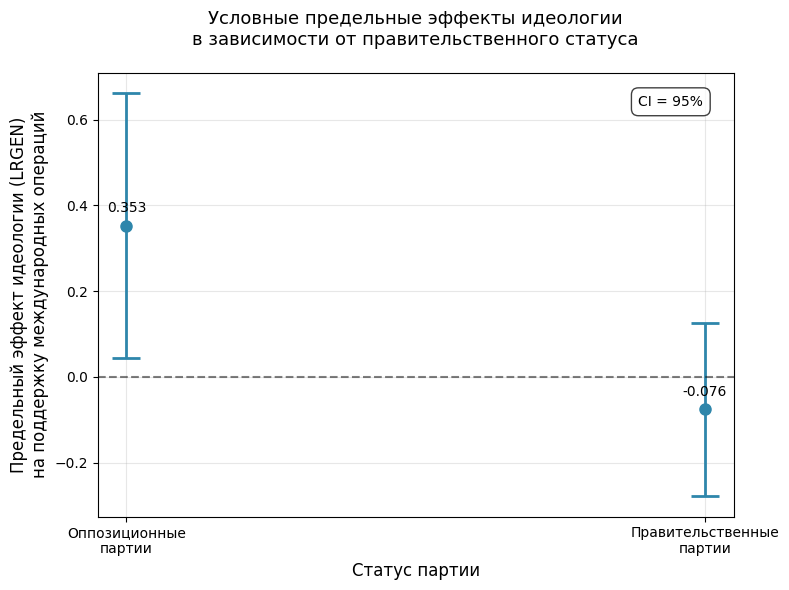

In [31]:
values = ches.gov.unique()
marg_effect = m7.params[1] + m7.params[11]*values
Cov_m3 = np.asmatrix(m7.cov_params())
se = (Cov_m3[1,1] + values**2*(Cov_m3[11,11]) + 2*values*Cov_m3[1,11])**(.5)

fig, ax = plt.subplots(figsize=(8, 6))

plt.errorbar(values, marg_effect, yerr=stats.norm.ppf(0.975)*se, 
             fmt='o', markersize=8, capsize=10, capthick=2,
             color='#2E86AB', linewidth=2)

ax.set(xticks=[0,1], 
       xticklabels=['Оппозиционные\nпартии', 'Правительственные\nпартии'])
ax.set_ylabel('Предельный эффект идеологии (LRGEN)\nна поддержку международных операций', 
              fontsize=12)
ax.set_xlabel('Статус партии', fontsize=12)
ax.set_title('Условные предельные эффекты идеологии\nв зависимости от правительственного статуса', 
             fontsize=13, pad=20)

ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)

for i, (x, y) in enumerate(zip(values, marg_effect)):
    ax.annotate(f'{y:.3f}', (x, y), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=10)
    
plt.annotate(text='CI = 95%', 
             xy=(0.85, 0.95), 
             xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.75),
             fontsize=10,
             verticalalignment='top')

plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig(PROJECT_ROOT.joinpath('figures/fig6'))

**Условные предельные эффекты идеологии (Модель 3.2)**

Представленный график отображает условные предельные эффекты идеологической позиции партии на поддержку международных военных операций в зависимости от ее правительственного статуса, рассчитанные при фиксированных значениях контрольных переменных.

Для оппозиционных партий предельный эффект идеологии является положительным и статистически значимым: смещение партии вправо по идеологическому спектру ассоциируется с увеличением вероятности поддержки применения военной силы. 95%-й доверительный интервал полностью расположен выше нулевой линии (хотя его нижняя граница практически накладывается на ноль), что указывает на устойчивость данного эффекта.

Напротив, для правительственных партий предельный эффект идеологии близок к нулю и статистически незначим: доверительный интервал пересекает нулевое значение, а точечная оценка имеет слабый отрицательный знак. Это свидетельствует об отсутствии систематической связи между идеологической позицией и поддержкой военных операций среди партий, входящих в правящую коалицию.

В целом график наглядно подтверждает результаты регрессионного анализа и указывает на выраженную асимметрию идеологического эффекта: идеология играет значимую роль в формировании позиций оппозиционных партий, тогда как для правительственных партий ее влияние существенно ослаблено или полностью нивелировано.


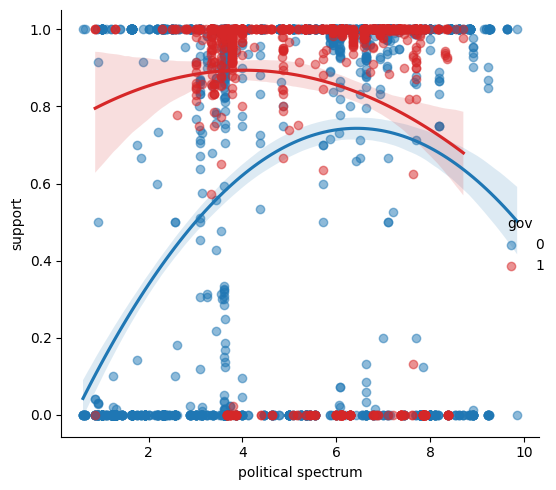

In [32]:
palette = sns.color_palette('tab10', 4)
custom_colors = [palette[0], palette[3]]

sns.lmplot(x ='lrgen', 
           y = 'support', 
           hue = 'gov', 
           data = ches, 
           ci = 95, 
           order = 2,
           palette=custom_colors,
           scatter_kws={'alpha': 0.5}
           ).set_axis_labels('political spectrum')

plt.tight_layout()
plt.show()

Представленный график визуализирует зависимость между идеологической позицией партии и уровнем поддержки международных военных операций с раздельным отображением для оппозиционных и правительственных партий и учетом возможной нелинейности.

Для оппозиционных партий наблюдается отчетливо выраженная нелинейная зависимость: по мере смещения от левых к умеренно правым позициям уровень поддержки военных операций существенно возрастает, однако на крайних правых значениях шкалы рост принимает отрицательный характер. Данный паттерн указывает на наличие вогнутой формы зависимости и свидетельствует о том, что максимальная поддержка характерна для умеренно правых оппозиционных партий, а не для идеологических экстремумов.

Для правительственных партий зависимость носит иной характер. Уровень поддержки в целом остается высоким по всему идеологическому спектру, а кривая имеет слабовыраженную форму перевернутой подковым с минимальными колебаниями. Это указывает на ослабление линейного идеологического эффекта и предполагает наличие более сложной, условной зависимости между идеологией и поддержкой военных операций внутри правящей коалиции.

Таким образом, график демонстрирует, что форма идеологического эффекта различается в зависимости от правительственного статуса партии и не может быть адекватно описана исключительно линейной спецификацией. Данный визуальный паттерн обосновывает необходимость включения в регрессионную модель квадратичных членов идеологии и их взаимодействий с правительственным статусом, реализованных в Модели 4.

In [33]:
ches['lrgen2_gov'] = ches['lrgen2'] * ches['gov']

y = ches['support']
X = ches.drop(columns=['support','combat','cooperative','humanitarian','country',])
X = sm.add_constant(X)

m8 = sm.GLM(y, X, family=sm.families.Binomial())
m8 = m8.fit(cov_type='cluster',cov_kwds={'groups': ches['country']})

print(m8.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                support   No. Observations:                 2848
Model:                            GLM   Df Residuals:                     2834
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1225.8
Date:                Thu, 25 Dec 2025   Deviance:                       2204.8
Time:                        00:04:11   Pearson chi2:                 3.14e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3240
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5550      1.963     -1.811      0.0

**Модель 4.2. Спецификация с квадратичным членом и переменной взаимодействия**

Модель 4.2 расширяет предыдущую спецификацию за счет включения квадратичного члена идеологии и его взаимодействия с правительственным статусом, что позволяет оценить, различается ли не только сила, но и форма идеологического эффекта для правящих и оппозиционных партий. Это позволяет оценить, различается ли не только сила, но и форма идеологического эффекта для правящих и оппозиционных партий.

Линейный эффект идеологии положителен, но лишь маргинально значим *($\beta$ = 1.315, p = 0.093)*, тогда как квадратичный член не достигает статистической значимости. Это указывает на то, что среди оппозиционных партий зависимость между идеологией и поддержкой применения военной силы носит преимущественно линейный характер, а проявление нелинейности неустойчиво.

Правительственный статус партии положителен и маргинально значим *($\beta$ = 3.835, p = 0.101)*, подтверждая существенно более высокий уровень поддержки военных операций со стороны партий, входящих в правящую коалицию.

Коэффициент при взаимодействии линейного идеологического члена с правительственным статусом является отрицательным, но статистически незначимым *($\beta$ = −0.890, p = 0.233)*, тогда как взаимодействие квадратичного члена *(rile2 × gov)* — положительным и также статистически незначимым *($\beta$ = 0.056, p = 0.445)*. В совокупности это предполагает, что для правительственных партий идеологический эффект может ослабляться и приобретать более сложную форму, однако доказательства устойчивой нелинейности и модерации ограничены в данной выборке.

В целом результаты модели подтверждают условность влияния идеологии: для оппозиционных партий эффект линейный и положительный, тогда как для правящих партий идеологическое влияние может ослабляться и приобретать сложную форму. Эти выводы уточняют результаты предыдущих моделей и демонстрируют, что правительственный статус партии влияет не только на силу, но и потенциально на форму идеологического эффекта.

In [34]:
t = summary_col(
        [m1, m2, m3, m4, m1_add, m2_add, m3_add, m4_add, m5, m6, m7, m8],
        stars=True,
        model_names=['model 1', 'model 2', 'model 3', 'model 4', 
                     'model 5', 'model 6', 'model 7', 'model 8',
                     'model 9', 'model 10', 'model 11', 'model 12'],
        info_dict={
            'N': lambda x: '{0:d}'.format(int(x.nobs)),
            'LLF': lambda x: '{:.3f}'.format(x.llf),
            'Pseudo R2': lambda x: '{:.3f}'.format(1 - (x.llf / x.llnull)),
            'AIC': lambda x: '{:.1f}'.format(x.aic),
        },
        regressor_order=[
            'const',
            'rile',
            'lrgen',
            'rile2',
            'lrgen2', 
            'gov',
            'rile_gov',
            'lrgen_gov',
            'rile2_gov',
            'lrgen2_gov',
            'wthdr',
            'alliance',
            'postcom',
            'pervote',
            'herf',
            'un',
            'nato',
            'eu'
        ],
        float_format='%.3f'
    )

print(t)
print("""
All models include cluster-robust standard errors.
Models 1-8 are based on a MARPOR sample
Models 5-8 are based on a limited sample (without German and Italian parties) 
Models 9-12 are based on a CHES sample
""")


            model 1   model 2   model 3   model 4   model 5   model 6   model 7   model 8   model 9   model 10  model 11  model 12
----------------------------------------------------------------------------------------------------------------------------------
const      -2.818**  -5.727*   -3.434*** -6.740**  -2.065*   -3.880*   -2.780**  -4.686**  -1.684*   -3.507*   -1.827**  -3.555*  
           (1.166)   (2.985)   (1.246)   (3.397)   (1.135)   (2.175)   (1.103)   (2.387)   (0.961)   (1.893)   (0.926)   (1.963)  
rile       0.509***  1.771*    0.636***  2.073*    0.419*    1.229*    0.570***  1.426*                                           
           (0.183)   (0.973)   (0.190)   (1.123)   (0.215)   (0.717)   (0.200)   (0.826)                                          
lrgen                                                                                      0.295*    1.307*    0.353**   1.314*   
                                                                                  

In [35]:
with open(PROJECT_ROOT.joinpath('tables/t1.tex'), 'w') as f:
    f.write(t.as_latex())

with open(PROJECT_ROOT.joinpath('tables/t1.html'), 'w') as f:
    f.write(t.as_html())

#### Байесовская статистка

Модель Zero-One Inflated Beta Regression (ZOIB), предложенная [Ospina & Ferrari (2012)](https://econpapers.repec.org/article/eeecsdana/v_3a56_3ay_3a2012_3ai_3a6_3ap_3a1609-1623.html), предназначена для анализа пропорциональных зависимых переменных на интервале [0;1], в которых встречается значительная масса наблюдений, принимающих граничные значения 0 и 1. В отличие от стандартной бета-регрессии, определенной только на открытом интервале (0;1), ZOIB позволяет одновременно моделировать как непрерывную часть распределения, так и дискретные вероятности нулевых и единичных исходов.

Данная модель представляет собой смесь трех компонентов: вероятности наблюдения нуля, вероятности наблюдения единицы и бета-распределения для значений внутри интервала (0;1). Каждая из этих составляющих может зависеть от набора объясняющих переменных, что обеспечивает высокую гибкость спецификации и позволяет учитывать различия в механизмах формирования экстремальных и промежуточных значений зависимой переменной.

Интерпретация коэффициентов в ZOIB осуществляется раздельно для каждого компонента модели. Коэффициенты инфляционных частей (для 0 и 1) интерпретируются в терминах логарифмических шансов соответствующих граничных исходов, тогда как параметры бета-компоненты отражают влияние факторов на условное математическое ожидание пропорции при условии, что наблюдение не является граничным. Несмотря на более сложную структуру и интерпретацию по сравнению с FLR, модель ZOIB позволяет более точно описывать распределения с выраженной концентрацией на границах и тем самым повышает качество эконометрического анализа.

**Априорные распределения**

Оценивание модели ZOIB проводилось в байесовской парадигме с использованием пакета `brms` для языка R. В рамках данного исследования априорные распределения для параметров модели задавались неявно и принимались равными значениям по умолчанию, реализованным в `brms`. Эти априоры относятся к классу слабоинформативных и предназначены для регуляризации оценок при сохранении доминирующей роли апостериорной информации, содержащейся в данных.

В частности, для коэффициентов регрессии во всех субмоделях (включая компоненты, отвечающие за вероятность нулевых и единичных исходов, а также за параметры бета-распределения) используются симметричные нормальные априорные распределения с нулевым математическим ожиданием и умеренной дисперсией на шкале функции связи. Это отражает предположение об отсутствии априорных предпочтений относительно направления эффекта и одновременно ограничивает вероятность экстремально больших значений параметров, которые могут приводить к численной нестабильности.

Для свободных членов применяются более широкие распределения с тяжелыми хвостами, допускающие существенные смещения базового уровня зависимой переменной, тогда как параметры масштаба и дисперсии (включая параметр точности бета-распределения) априорно ограничиваются положительной областью и регуляризуются стандартными распределениями, принятыми в brms для соответствующих семейств.

Использование слабоинформативных априоров представляется обоснованным в контексте настоящего исследования по нескольким причинам. Во-первых, отсутствие надежной априорной информации о величине и направлении эффектов делает нежелательным применение жестко информативных априоров. Во-вторых, выбранный подход снижает риск переобучения и улучшает идентифицируемость параметров в сложной многокомпонентной модели, такой как ZOIB. Наконец, стандартные априоры обеспечивают воспроизводимость результатов и соответствуют устоявшейся практике прикладного байесовского моделирования.

In [36]:
def extract_inference_data(df, n_chains=4):
    n_draws = df.shape[0] // n_chains

    posterior = {
        col: df[col].values.reshape((n_chains, n_draws))
        for col in df.columns
    }

    return az.from_dict(posterior=posterior)

In [37]:
trace = extract_inference_data(
    pd.read_csv(PROJECT_ROOT.joinpath('bmodels/converted/zoib_gov.csv'))
    )

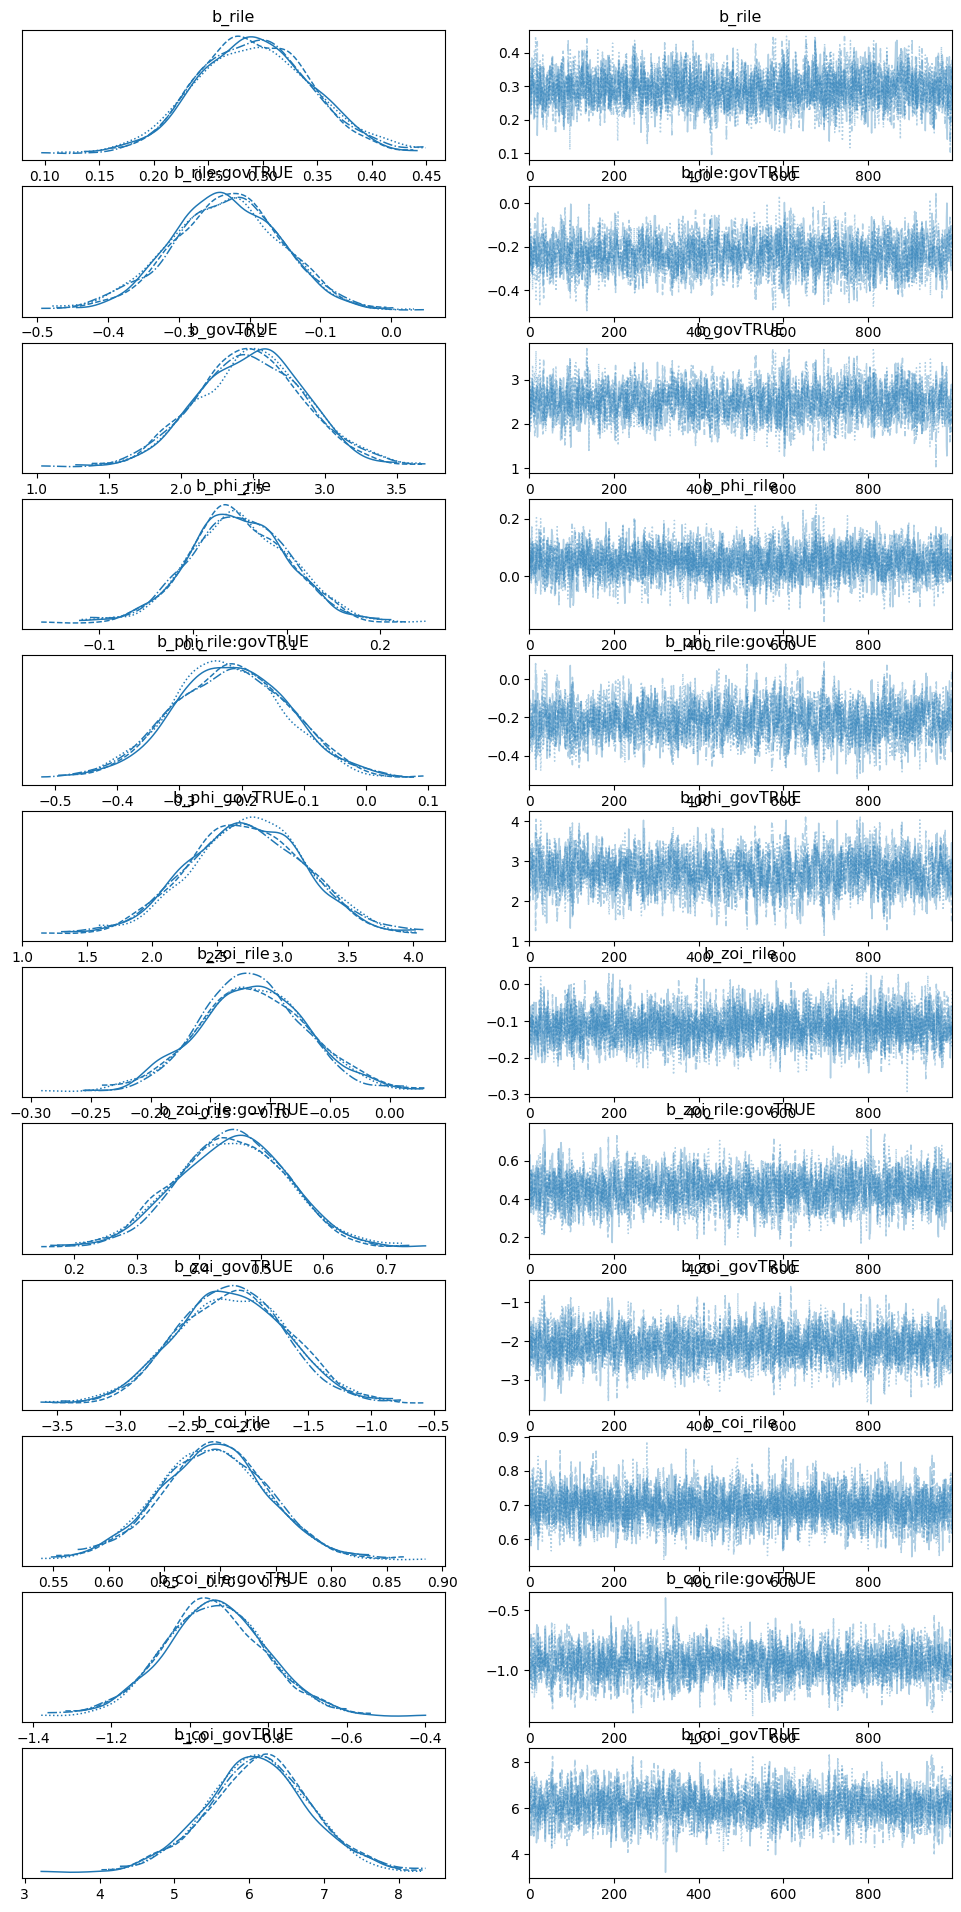

In [38]:
az.plot_trace(trace.posterior, 
              var_names=[
                  'b_rile', 'b_rile:govTRUE','b_govTRUE',
                  'b_phi_rile', 'b_phi_rile:govTRUE','b_phi_govTRUE',
                  'b_zoi_rile', 'b_zoi_rile:govTRUE','b_zoi_govTRUE',
                  'b_coi_rile', 'b_coi_rile:govTRUE','b_coi_govTRUE',
                  ],
              compact=True)

plt.savefig(PROJECT_ROOT.joinpath('figures/fig7'))

Диагностики позволяют нам проверить сходимость алгоритма. Одна из таких диагностик – trace plot, график, отображающий значения параметров на каждой итерации и позволяющий увидеть, как они изменяются со временем.

Распределение $\beta$ на графике слева похоже на нормальное, временной ряд для $\beta$ на графике справа – стационарный (постоянные, не зависящие от времени итерации). Это позволяет предположить, что алгоритм сошелся.

In [39]:
summary = az.summary(
    trace.posterior,
    var_names=[
        'b_rile', 'b_rile:govTRUE','b_govTRUE',
        'b_phi_rile', 'b_phi_rile:govTRUE','b_phi_govTRUE',
        'b_zoi_rile', 'b_zoi_rile:govTRUE','b_zoi_govTRUE',
        'b_coi_rile', 'b_coi_rile:govTRUE','b_coi_govTRUE',
        ]
)
summary

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
b_rile              0.292  0.053   0.200    0.398      0.001    0.001   
b_rile:govTRUE     -0.234  0.077  -0.375   -0.083      0.002    0.001   
b_govTRUE           2.493  0.372   1.810    3.196      0.009    0.005   
b_phi_rile          0.049  0.053  -0.044    0.152      0.001    0.001   
b_phi_rile:govTRUE -0.218  0.093  -0.388   -0.036      0.002    0.001   
b_phi_govTRUE       2.728  0.451   1.908    3.588      0.011    0.007   
b_zoi_rile         -0.114  0.045  -0.197   -0.028      0.001    0.001   
b_zoi_rile:govTRUE  0.453  0.088   0.293    0.618      0.002    0.001   
b_zoi_govTRUE      -2.108  0.438  -2.947   -1.322      0.009    0.007   
b_coi_rile          0.695  0.049   0.606    0.790      0.001    0.001   
b_coi_rile:govTRUE -0.938  0.129  -1.173   -0.685      0.003    0.002   
b_coi_govTRUE       6.131  0.682   4.840    7.462      0.014    0.011   

                    ess_bulk  ess_tail  r_hat  
b_rile                2390.0    2500.0    1.0  
b_rile:govTRUE        1741.0    2468.0    1.0  
b_govTRUE             1803.0    2498.0    1.0  
b_phi_rile            2472.0    3166.0    1.0  
b_phi_rile:govTRUE    1658.0    2355.0    1.0  
b_phi_govTRUE         1642.0    2402.0    1.0  
b_zoi_rile            3461.0    2852.0    1.0  
b_zoi_rile:govTRUE    2614.0    2494.0    1.0  
b_zoi_govTRUE         2614.0    2630.0    1.0  
b_coi_rile            3632.0    2854.0    1.0  
b_coi_rile:govTRUE    2564.0    2639.0    1.0  
b_coi_govTRUE         2500.0    2642.0    1.0

In [40]:
t = az.summary(trace.posterior)

with open(PROJECT_ROOT.joinpath('tables/t2.html'), 'w') as f:
    f.write(t.to_html())

/Users/solodov_ea/Desktop/проект/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


**Диагностика сходимости модели**
 
Для всех параметров модели значение $\hat{R}$ равно 1.0. Это указывает на отсутствие различий между цепями и свидетельствует о достижении стационарного распределения. В прикладной байесовской практике значения $\hat{R} < 1.01$ считаются признаком хорошей сходимости, таким образом, полученные результаты удовлетворяют строгим критериям конвергенции.

Показатели эффективного размера выборки как для основной части апостериорного распределения *(ess_bulk)*, так и для хвостов *(ess_tail)* во всех случаях превышают 1 600 и в ряде параметров достигают значений свыше 3 000. Это свидетельствует о низкой автокорреляции между последовательными выборками и высокой эффективности алгоритма NUTS. Достаточно высокие значения *ess_tail* особенно важны для корректной оценки достоверных интервалов.

Монте-Карло ошибки для апостериорных средних *(mcse_mean)* и стандартных отклонений *(mcse_sd)* малы по сравнению с соответствующими оценками параметров. Во всех случаях отношение MCSE к стандартному отклонению существенно ниже эмпирического порога в 0.1, что указывает на высокую точность численной аппроксимации апостериорных моментов.

Совокупность диагностических показателей указывает на хорошую сходимость модели и отсутствие численных проблем при оценивании. Ни для одного из параметров не наблюдается признаков плохого смешивания цепей, недостаточного числа эффективных наблюдений или нестабильности апостериорных оценок. Это позволяет считать полученные апостериорные распределения надёжной основой для последующей интерпретации коэффициентов и эконометрических выводов.

**Модель 1.3. Спецификация с переменной взаимодействия**

В отличие от FLR, ZOIB-модель позволяет разложить влияние объясняющих переменных на несколько концептуально различных механизмов: (1) условное среднее пропорции внутри интервала (0;1), (2) степень концентрации распределения вокруг этого среднего, (3) вероятность достижения экстремальных значений и (4) условную вероятность наблюдения единичного исхода. Такой подход обеспечивает более детализированное представление о структуре зависимой переменной.

* Условное среднее бета-распределения ($\mu$-параметр)

Оценки для компоненты условного среднего указывают на устойчивый и положительный эффект идеологии среди оппозиционных партий: смещение вправо по идеологическому спектру связано с увеличением среднего уровня поддержки военных операций *($\beta$ = 0.292, 95% HDI: [0.200; 0.398])*. Этот результат полностью согласуется с выводами, полученными в рамках логит-модели, и подтверждает наличие систематического идеологического градиента в оппозиции.

Переменная взаимодействия идеологии имеет отрицательный и статистически достоверный характер *($\beta$ = −0.234, 95% HDI: [−0.375; −0.083])*, что указывает на заметное ослабление идеологического эффекта в группе правящих партий. В совокупности линейный эффект идеологии для правительственных партий существенно меньше и статистически неотличим от нуля *($\beta$ = 0.059, 95% HDI: [−0.057; 0.170])*. Это свидетельствует о том, что нахождение у власти нивелирует различия между левыми и правыми партиями по уровню средней поддержки применения военной силы.

При этом сам правительственный статус оказывает сильное и положительное влияние на условное среднее зависимой переменной *($\beta$ = 2.493, 95% HDI: [1.810; 3.196])*. Таким образом, независимо от идеологической позиции, партии, входящие в правящую коалицию, в среднем демонстрируют более высокий уровень поддержки военных операций. Данный вывод также воспроизводит ключевой результат FLR и подтверждает его устойчивость при более гибкой спецификации распределения.

* Точность бета-распределения ($\phi$-параметр)

Параметры компоненты точности отражают степень однородности наблюдений вокруг условного среднего. Для оппозиционных партий идеология не оказывает заметного влияния на вариативность пропорции *($\beta$ = 0.049, 95% HDI: [−0.044; 0.152])*, что указывает на сопоставимый уровень разброса значений для левых и правых партий вне правительства.

Однако взаимодействие идеологии с институциональным статусом имеет отрицательный и достоверный эффект *($\beta$ = −0.218, 95% HDI: [−0.388; −0.036])*. Это означает, что по мере смещения вправо правящие партии демонстрируют большую гетерогенность позиций относительно поддержки военных операций. В то же время сам правительственный статус существенно повышает параметр точности *($\beta$ = 2.728, 95% HDI: [1.908; 3.588])*, что указывает на более концентрированное распределение наблюдений среди правящих партий в целом. Таким образом, власть одновременно ассоциируется с большей дисциплиной, но и с ростом внутренней вариативности среди правых партий.

* Вероятность инфляции экстремальных исходов ($\alpha$-параметр)

Компонента инфляции экстремальных значений отражает вероятность того, что наблюдение принимает одно из граничных значений (0 или 1). Для оппозиционных партий идеологическое смещение вправо связано со снижением вероятности таких экстремальных исходов *($\beta$ = −0.114, 95% HDI: [−0.197; −0.028])*. Это указывает на то, что более правые оппозиционные партии реже демонстрируют полностью консолидированные позиции и чаще занимают промежуточные позиции.

В противоположность этому, переменная взаимодействие имеет положительный и статистически достоверный эффект *($\beta$ = 0.453, 95% HDI: [0.293; 0.618])*. Следовательно, для правящих партий смещение вправо по идеологическому спектру, напротив, повышает вероятность достижения экстремальных значений. Этот результат дополняет выводы FLR, показывая, что эффект власти проявляется не только на уровне среднего, но и в структуре распределения голосов.

Вероятность инфляции единиц ($\gamma$-параметр)

Оценки для компоненты инфляции единиц характеризуют факторы, влияющие на вероятность достижения максимального значения зависимой переменной, то есть полной поддержки военных операций. Идеология оказывает сильное и устойчивое положительное влияние на эту вероятность среди оппозиционных партий (($\beta$ = 0.695, 95% HDI: [0.606; 0.790])(). Это означает, что по мере смещения вправо возрастает масса распределения в точке 1.

Переменная взаимодействия, однако, имеет выраженный отрицательный эффект *($\beta$ = −0.938, 95% HDI: [−1.173; −0.685])*, что указывает на резкое ослабление данного идеологического эффекта в группе правящих партий. В результате для правящих партий предельный эффект идеологии на вероятность единичного исхода становится отрицательным и статистически достоверным *($\beta$ = −0.244, 95% HDI: [−0.480; −0.009])*. Иными словами, среди правящих партий более правые позиции ассоциируются с меньшей вероятностью полной консолидации поддержки.

При этом сам правительственный статус оказывает крайне сильное положительное влияние на вероятность единичного исхода *($\beta$ = 6.131, 95% HDI: [4.840; 7.462])*, что свидетельствует о принципиально иной логике формирования поддержки военных операций в условиях нахождения у власти.

В целом результаты ZOIB-модели подтверждают ключевые выводы FLR о положительном идеологическом эффекте в оппозиции и его ослаблении в правительстве. Вместе с тем ZOIB-спецификация демонстрирует, что данный эффект является многомерным: правительственный статус влияет не только на средний уровень поддержки, но и на степень консолидации, вариативность и вероятность экстремальных позиций. Это указывает на то, что нахождение у власти трансформирует не только интенсивность, но и саму структуру идеологического влияния на поддержку применения военной силы.

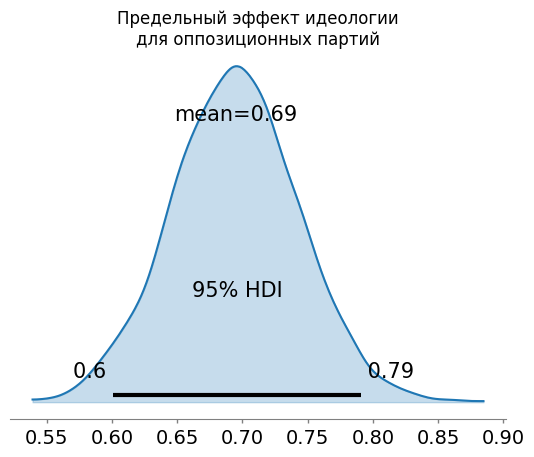

In [41]:
az.plot_posterior(
    trace.posterior,
    var_names=['b_coi_rile'],
    hdi_prob=0.95, 
    #ref_val=0,
    fill_alpha=0.25, 
    #ref_val_color='black'
    )
plt.title('Предельный эффект идеологии\nдля оппозиционных партий');
plt.savefig(PROJECT_ROOT.joinpath('figures/fig8'))

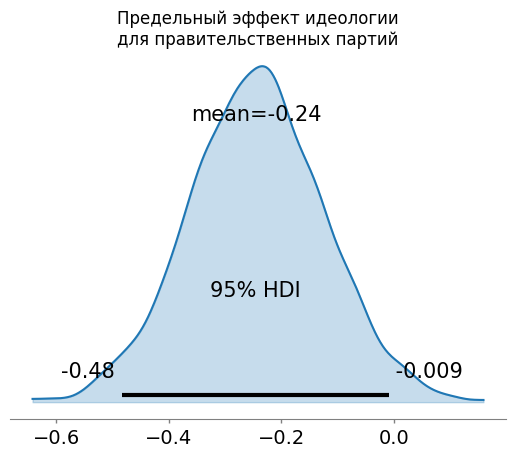

In [42]:
diff = trace.posterior['b_coi_rile'] + trace.posterior['b_coi_rile:govTRUE']

az.plot_posterior(
    diff,
    hdi_prob=0.95, 
    #ref_val=0,
    fill_alpha=0.25, 
    #ref_val_color='black'
    )
plt.title('Предельный эффект идеологии\nдля правительственных партий');
plt.savefig(PROJECT_ROOT.joinpath('figures/fig9'))

### Регрессионный анализ данных (Гипотеза 2)

Гипотеза 2 предполагает, что влияние идеологической позиции партии на поддержку применения военной силы зависит от специфики самой операции, включая ее цели, уровень риска, легитимность и ожидаемые издержки. 

Для проверки этой гипотезы мы включаем в модели переменные взаимодействия между идеологией партии и типом операции: операции с высокой интенсивностью боевых действий (combat), операции кооперативного характера (cooperative) и операции с ясными гуманитарными целям (humanitarian). Такой подход позволяет оценить, изменяется ли сила и направление идеологического эффекта в зависимости от характера миссии.

#### Частотная статистика

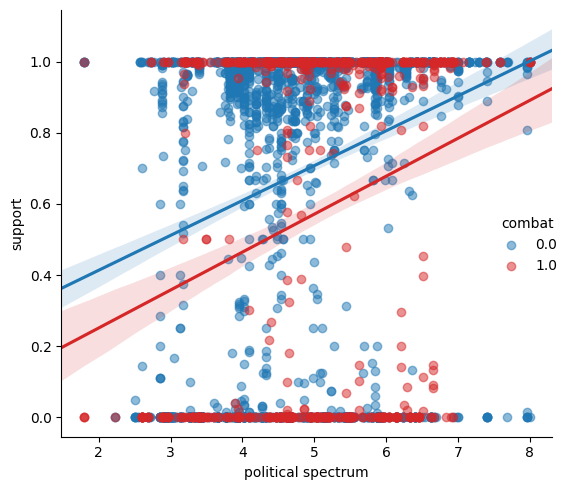

In [43]:
palette = sns.color_palette('tab10', 4)
custom_colors = [palette[0], palette[3]]

sns.lmplot(x ='rile', 
           y = 'support', 
           hue = 'combat', 
           data = marpor, 
           ci = 95, 
           palette=custom_colors,
           truncate=False,
           scatter_kws={'alpha': 0.5}
           ).set_axis_labels('political spectrum')

plt.tight_layout()
plt.show()

Представленная визуализация демонстрирует характер связи между идеологической позицией политических партий и их готовностью голосовать за участие в международных военных операциях. Анализ разделен на две категории: операции, связанные с высокой интенсивностью боевых действий и прямым риском военных потерь (конвенциональная война и контрповстанческие операции), и все прочие типы интервенций.

В обоих случаях наблюдается статистически выраженная положительная зависимость. Смещение партийной позиции по идеологической шкале вправо систематически коррелирует с возрастанием уровня поддержки применения военной силы. Линейные аппроксимирующие тренды имеют устойчивый восходящий наклон, что подтверждает наличие значимого и однонаправленного идеологического эффекта.

Таким образом, предварительный визуальный анализ данных позволяет предположить, что идеологическая диспозиция является существенным и последовательным предиктором голосования по вопросам военных операций. При этом выявленная закономерность носит общий характер и не опосредована спецификой типа операции (ее интенсивностью или связанным с ней уровнем риска). Другими словами, идеологический градиент в поддержке использования силы проявляется как в случае высокорисковых, так и в случае прочих военных операций.

In [44]:
marpor = marpor.drop(columns={'rile2', 'rile_gov', 'rile2_gov'})
marpor['rile_combat'] = marpor['rile']*marpor['combat']

y = marpor['support']
X = marpor.drop(columns=['support','cooperative','humanitarian','country'])
X = sm.add_constant(X)

m9 = sm.GLM(y, X, family=sm.families.Binomial())
m9 = m9.fit(cov_type='cluster',cov_kwds={'groups': marpor['country']})

print(m9.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                support   No. Observations:                 4097
Model:                            GLM   Df Residuals:                     4084
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1963.6
Date:                Thu, 25 Dec 2025   Deviance:                       3507.6
Time:                        00:04:13   Pearson chi2:                 3.49e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2468
Covariance Type:              cluster                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -2.9141      1.383     -2.106      

**Модель 1.4. Идеология и поддержка операций высокой интенсивности**

Модель включает переменную взаимодействия между идеологической позицией партии и дамми-переменной, фиксирующей военные операции, сопряженные с высокоинтенсивными боевыми действиями. Это позволяет проверить гипотезу о том, что положительная связь правой идеологии с поддержкой применения силы опосредована характером операции, в частности, является ли она высокоинтенсивной боевой миссией. Объяснительная способность модели является существенной *(Pseudo R² = 0.247)*.

Линейный эффект идеологии для операций, не относящихся к высокоинтенсивным боевым действиям, оказывается положительным и статистически значимым *($\beta$ = 0.540, p = 0.013)*. Это подтверждает базовую закономерность: смещение вправо по идеологическому спектру последовательно связано с ростом поддержки операций, не связанных с прямыми боевыми действиями.

Ключевой результат касается переменной взаимодействия. Ее коэффициент является отрицательным, но статистически незначимым *($\beta$ = -0.076, p = 0.796)*. Это означает, что наклон идеологического эффекта для боевых операций статистически не отличается от наклона для операций иного типа. Гипотеза о том, что положительная взаимосвязь заметно усиливается или ослабляется в контексте именно операций с высокой интенсивностью боевых действий и риском потерь, не находит подтверждения в данных.

Таким образом, результаты модели указывают на то, что выявленная идеологическая диспозиция в отношении применения военной силы носит универсальный, а не контекстно-зависимый характер. Положительная связь правой идеологии с поддержкой интервенций является устойчивой и не зависит систематическим образом от специфики операции, в частности, от того, сопряжена ли она с высокой интенсивностью боевых действий и риском потерь.

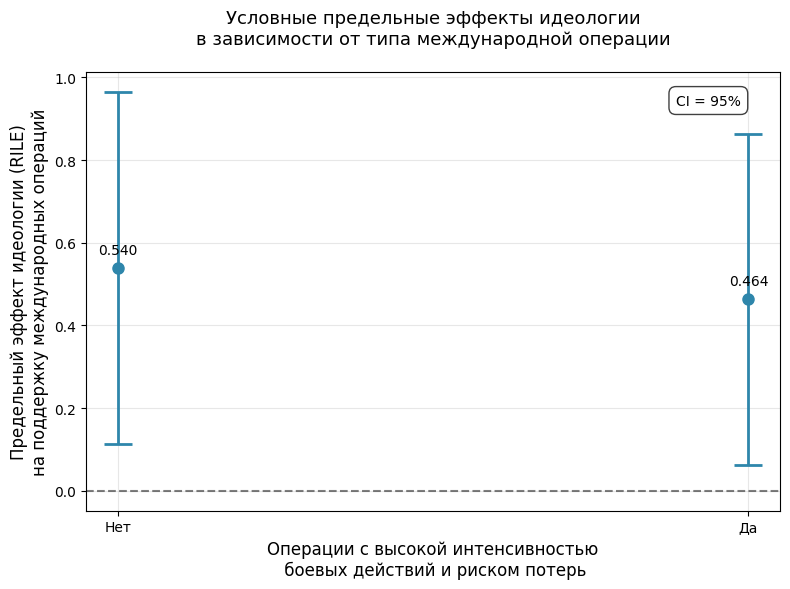

In [45]:
values = marpor.combat.unique()
marg_effect = m9.params[1] + m9.params[12]*values
Cov_m3 = np.asmatrix(m9.cov_params())
se = (Cov_m3[1,1] + values**2*(Cov_m3[12,12]) + 2*values*Cov_m3[1,12])**(.5)

fig, ax = plt.subplots(figsize=(8, 6))

plt.errorbar(values, marg_effect, yerr=stats.norm.ppf(0.975)*se, 
             fmt='o', markersize=8, capsize=10, capthick=2,
             color='#2E86AB', linewidth=2)

ax.set(xticks=[0,1], 
       xticklabels=['Нет', 'Да'])
ax.set_ylabel('Предельный эффект идеологии (RILE)\nна поддержку международных операций', 
              fontsize=12)
ax.set_xlabel('Операции с высокой интенсивностью\n боевых действий и риском потерь', fontsize=12)
ax.set_title('Условные предельные эффекты идеологии\nв зависимости от типа международной операции', 
             fontsize=13, pad=20)

ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)

for i, (x, y) in enumerate(zip(values, marg_effect)):
    ax.annotate(f'{y:.3f}', (x, y), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=10)
    
plt.annotate(text='CI = 95%', 
             xy=(0.85, 0.95), 
             xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.75),
             fontsize=10,
             verticalalignment='top')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(PROJECT_ROOT.joinpath('figures/fig10'))

**Условные предельные эффекты идеологии (Модель 1.4)**

Представленный график отображает условные предельные эффекты идеологической позиции партии на поддержку международных военных операций в зависимости от типа военной операции, рассчитанные при фиксированных значениях контрольных переменных.

Для голосований за операции с высокой интенсивностью боевых действий и риском потерь эффект идеологии является положительным и статистически значимым: смещение партии вправо по идеологическому спектру ассоциируется с увеличением вероятности поддержки применения военной силы. 95%-й доверительный интервал полностью расположен выше нулевой линии, что указывает на устойчивость данного эффекта.

Однако, также и для голосования за прочие военные операции эффект идеологии является положительным и статистически значимым. 95%-й доверительный интервал полностью расположен выше нулевой линии, что указывает на устойчивость данного эффекта.

Более того, доверительные интервалы для обоих типов операций накладываются друг на друга, что свидетельствует о том, что выявленная идеологическая диспозиция в отношении применения военной силы носит универсальный, а не контекстно-зависимый характер. 

В целом график наглядно подтверждает результаты регрессионного анализа и указывает на отсутствие асимметрии идеологического эффекта: идеология играет значимую роль в формировании позиций как по операциям с высокой интенсивностью боевых действий и риском потерь, так и любых иных операций.

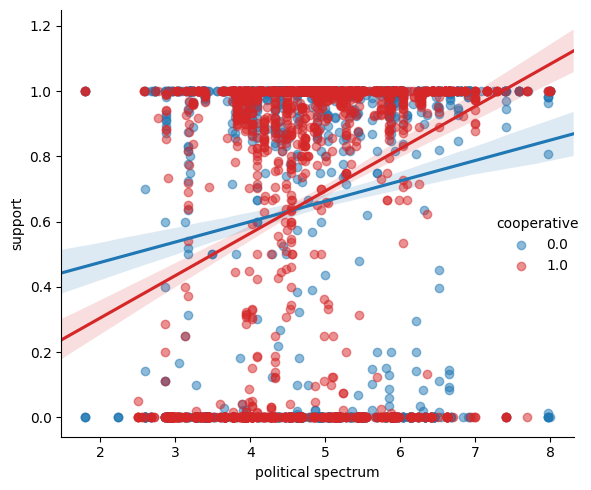

In [46]:
palette = sns.color_palette('tab10', 4)
custom_colors = [palette[0], palette[3]]

sns.lmplot(x ='rile', 
           y = 'support', 
           hue = 'cooperative', 
           data = marpor, 
           ci = 95, 
           palette=custom_colors,
           truncate=False,
           scatter_kws={'alpha': 0.5}
           ).set_axis_labels('political spectrum')

plt.tight_layout()
plt.show()

Представленная визуализация демонстрирует характер связи между идеологической позицией политических партий и их готовностью голосовать за участие в международных военных операциях. Анализ разделен на две категории: операции с кооперативным характером (военно-техническое сотрудничество, обучение, логистическая поддержка и пр.), и все прочие типы интервенций.

Для операция с кооперативных характером партий прослеживается более выраженная положительная зависимость: по мере смещения вправо по идеологическому спектру уровень поддержки военных операций возрастает. Линейный тренд имеет отчетливо восходящий характер, что указывает на наличие систематического идеологического эффекта для такого вида операций.

В то же время для всех прочих операций также наблюдается положительная зависимость, однако гораздо менее выраженная: наклон линии тренда является более слабым. Это указывает на существенное ослабление идеологического эффекта для всех прочих операций, кроме операций с кооперативным характером.

Таким образом, график свидетельствует о том, что связь между идеологией и поддержкой применения военной силы носит условный характер и существенно различается в зависимости от типа военной операции. Другими словами, идеологический градиент в поддержке использования силы проявляется как в случае кооперативных, так и в случае прочих военных операций, однако для первых он является значительно более выраженным.

In [47]:
marpor = marpor.drop(columns={'rile_combat'})
marpor['rile_cooperative'] = marpor['rile']*marpor['cooperative']

y = marpor['support']
X = marpor.drop(columns=['support','combat','humanitarian','country'])
X = sm.add_constant(X)

m10 = sm.GLM(y, X, family=sm.families.Binomial())
m10 = m10.fit(cov_type='cluster',cov_kwds={'groups': marpor['country']})

print(m10.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                support   No. Observations:                 4097
Model:                            GLM   Df Residuals:                     4084
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1953.7
Date:                Thu, 25 Dec 2025   Deviance:                       3487.8
Time:                        00:04:13   Pearson chi2:                 3.52e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2504
Covariance Type:              cluster                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.9559      0.806  

**Модель 2.4. Идеология и поддержка кооперативных операций**

Модель включает переменную взаимодействия между идеологиейи типом операции, классифицированной как кооперативная или нет. Эта спецификация проверяет гипотезу о том, что связь идеологии с поддержкой применения силы вариативна в зависимости от характера миссии.

Линейный эффект идеологии для операций, не относящихся к категории кооперативных, является положительным и статистически значимым *($\beta$ = 0.338, p = 0.012)*. Это подтверждает базовую тенденцию, согласно которой партии с более правой идеологической позицией демонстрируют более высокую поддержку развертываний ВС в рамках различных военных операций.

Ключевой результат касается переменной взаимодействия. Ее коэффициент является положительным и статистически значимым *($\beta$  = 0.372, p = 0.016)*. Это указывает на то, что характер операции систематически модифицирует идеологический эффект. Для кооперативных операций совокупный наклон зависимости поддержки от идеологии является суммой основного эффекта и эффекта взаимодействия: *0.338 + 0.372 = 0.710*. Таким образом, положительная связь между правой идеологией и поддержкой применения силы оказывается почти в два раза сильнее в контексте кооперативных международных миссий по сравнению с операциями некооперативного характера.

Коэффициент при переменной *cooperative* является отрицательным и статистически значимым *($\beta$  = -1.836, p = 0.032)*. Это означает, что для гипотетической партии с нулевой позицией на шкале идеологии (крайне левая) кооперативные операции получают существенно меньшую поддержку, чем некооперативные.

Комбинация знаков формирует пересекающийся эффект взаимодействия. Итоговый идеологический градиент для кооперативных операций значительно круче. Правые партии поддерживают их даже больше, чем некооперативные, в то время как левые партии - существенно меньше.

Таким образом, результаты модели подтверждают гипотезу о значимом опосредующем эффекте типа операции. Взаимосвязь между идеологией и поддержкой применения военной силы не является универсальной, а существенно зависит от кооперативного характера миссии: правые партии являются особенно активными сторонниками именно кооперативных форм военного вмешательства.

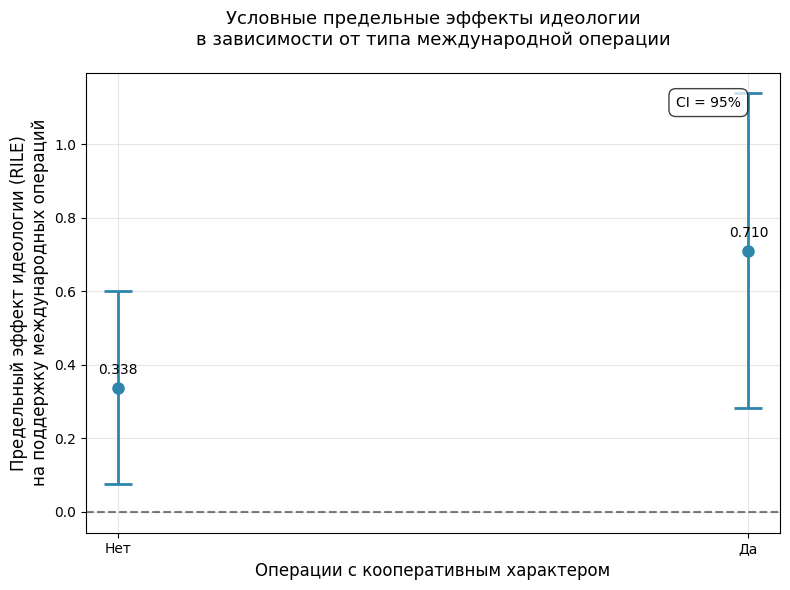

In [48]:
values = marpor.cooperative.unique()
marg_effect = m10.params[1] + m10.params[12]*values
Cov_m3 = np.asmatrix(m10.cov_params())
se = (Cov_m3[1,1] + values**2*(Cov_m3[12,12]) + 2*values*Cov_m3[1,12])**(.5)

fig, ax = plt.subplots(figsize=(8, 6))

plt.errorbar(values, marg_effect, yerr=stats.norm.ppf(0.975)*se, 
             fmt='o', markersize=8, capsize=10, capthick=2,
             color='#2E86AB', linewidth=2)

ax.set(xticks=[0,1], 
       xticklabels=['Нет', 'Да'])
ax.set_ylabel('Предельный эффект идеологии (RILE)\nна поддержку международных операций', 
              fontsize=12)
ax.set_xlabel('Операции с кооперативным характером', fontsize=12)
ax.set_title('Условные предельные эффекты идеологии\nв зависимости от типа международной операции', 
             fontsize=13, pad=20)

ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)

for i, (x, y) in enumerate(zip(values, marg_effect)):
    ax.annotate(f'{y:.3f}', (x, y), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=10)
    
plt.annotate(text='CI = 95%', 
             xy=(0.85, 0.95), 
             xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.75),
             fontsize=10,
             verticalalignment='top')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(PROJECT_ROOT.joinpath('figures/fig11'))

**Условные предельные эффекты идеологии (Модель 2.4)**

Представленный график отображает условные предельные эффекты идеологической позиции партии на поддержку международных военных операций в зависимости от типа военной операции, рассчитанные при фиксированных значениях контрольных переменных.

Для кооперативных операций предельный эффект идеологии является положительным и статистически значимым на общепринятых уровнях. Точечная оценка эффекта расположена выше нуля, а соответствующий 95% доверительный интервал не включает нулевое значение. Это свидетельствует об устойчивой положительной связи: смещение партийной идеологии вправо приводит к статистически значимому увеличению вероятности поддержки данного типа интервенций.

Для некооперативных операций (прочие типы) предельный эффект также демонстрирует положительную и статистически значимую связь. Однако визуальное сравнение интервальных оценок позволяет сделать содержательное наблюдение: точечная оценка эффекта для кооперативных операций существенно выше. Хотя доверительные интервалы для двух типов операций частично перекрываются, что формально указывает на отсутствие статистически значимого различия между ними на данном уровне уверенности, наблюдаемое расхождение в точечных оценках согласуется с гипотезой о более выраженном идеологическом градиенте поддержки именно кооперативных миссий.

График подтверждает, что связь между правой идеологией и поддержкой применения силы систематически сильнее для операций кооперативного характера. Таким образом, идеологический раскол в вопросе военных интервенций не является однородным, а варьирует в зависимости от стратегического профиля операции, достигая максимальной выраженности в контексте миссий, предполагающих совместные действия и разделение бремени с союзниками.

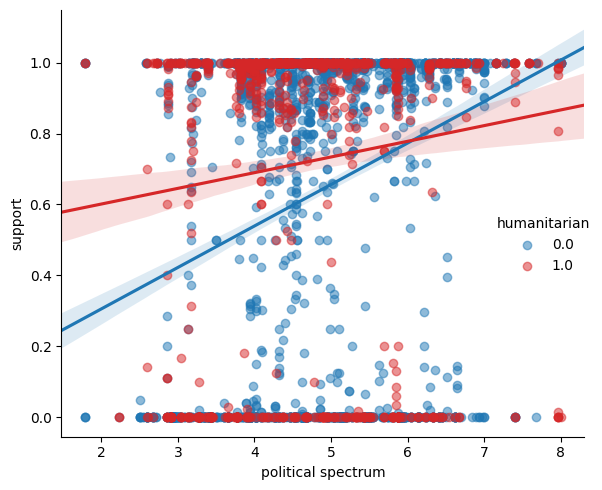

In [49]:
palette = sns.color_palette('tab10', 4)
custom_colors = [palette[0], palette[3]]

sns.lmplot(x ='rile', 
           y = 'support', 
           hue = 'humanitarian', 
           data = marpor, 
           ci = 95, 
           palette=custom_colors,
           truncate=False,
           scatter_kws={'alpha': 0.5}
           ).set_axis_labels('political spectrum')

plt.tight_layout()
plt.show()

Представленная визуализация демонстрирует характер связи между идеологической позицией политических партий и их готовностью голосовать за участие в международных военных операциях. Анализ разделен на две категории: операции с ясными гуманитарными целями, высокой международной легитимностью и низким непосредственным риском (гуманитарная помощь, ликвидация ЧС и пр.), и все прочие типы интервенций.

Для операция с ясными гуманитарными целями прослеживается гораздо менее выраженная положительная зависимость: по мере смещения вправо по идеологическому спектру уровень поддержки военных операций незначительно возрастает. Тем не менее линейный тренд имеет отчетливо восходящий характер, что указывает на наличие систематического идеологического эффекта для такого вида операций.

В то же время для всех прочих операций также наблюдается положительная зависимость, однако гораздо более выраженная: наклон линии тренда является более сильным. Это указывает на существенное усиление идеологического эффекта для всех прочих операций, кроме операций с кооперативным характером.

Таким образом, график свидетельствует о том, что связь между идеологией и поддержкой применения военной силы носит условный характер и существенно различается в зависимости от типа военной операции. Другими словами, идеологический градиент в поддержке использования силы проявляется как в случае операций с ясными гуманитарными целями, так и в случае прочих военных операций, однако для первых он является значительно менее выраженным.

In [50]:
marpor = marpor.drop(columns={'rile_cooperative'})
marpor['rile_humanitarian'] = marpor['rile']*marpor['humanitarian']

y = marpor['support']
X = marpor.drop(columns=['support','combat','cooperative','country'])
X = sm.add_constant(X)

m11 = sm.GLM(y, X, family=sm.families.Binomial())
m11 = m11.fit(cov_type='cluster',cov_kwds={'groups': marpor['country']})

print(m11.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                support   No. Observations:                 4097
Model:                            GLM   Df Residuals:                     4084
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1950.4
Date:                Thu, 25 Dec 2025   Deviance:                       3481.3
Time:                        00:04:13   Pearson chi2:                 3.55e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2516
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -3.3847      1.26

**Модель 3.4. Идеология и поддержка гуманитарных операций**

Модель проверяет гипотезу о вариации идеологического эффекта в зависимости от характера военной операции. Для этого в спецификацию включено взаимодействие между идеологией и дамми-переменной, фиксирующей операции с ясными гуманитарными целями *(humanitarian)*.

Базовый идеологический эффект для операций, не относящихся к категории гуманитарных, является положительным и высоко статистически значимым *($\beta$ = 0.612, p = 0.002)*. Это подтверждает устойчивый основной тренд: правые партии систематически демонстрируют более высокую поддержку применения военной силы в «традиционном» контексте.

Ключевым объектом анализа является коэффициент при переменной взаимодействия. Он имеет отрицательный знак и находится на границе статистической значимости *($\beta$ = -0.347, p = 0.066)*. Этот результат позволяет сделать два взаимосвязанных вывода:

1) Направление эффекта: отрицательный знак коэффициента указывает на то, что положительная связь между правой идеологией и поддержкой операции ослабевает, когда операция имеет гуманитарную составляющую;
2) Статистическая неопределенность: маргинальная значимость *(p = 0.066)* свидетельствует о том, что данное ослабление, хотя и является содержательно интуитивным, в данных не достигает уровня строгой статистической устойчивости, характерного для других выявленных закономерностей.

Предельный идеологический эффект для гуманитарных операций рассчитывается как сумма: *0.612 + (-0.347) = 0.265*. Таким образом, хотя связь остается положительной, ее величина для гуманитарных миссий оказывается примерно в два раза слабее, чем для негуманитарных.

Результаты модели частично поддерживают гипотезу об опосредующей роли типа операции, но с важной оговоркой. Полученные оценки позволяют предположить, что идеологический раскол в поддержке применения силы несколько сглаживается, когда международная операция мотивирована гуманитарными целями. Правые партии сохраняют более высокую, чем левые, склонность к поддержке таких операций, но разрыв между идеологическими флангами становится менее выраженным. Однако недостаточная статистическая надежность эффекта взаимодействия указывает на то, что этот вывод требует дальнейшей проверки и уточнения.

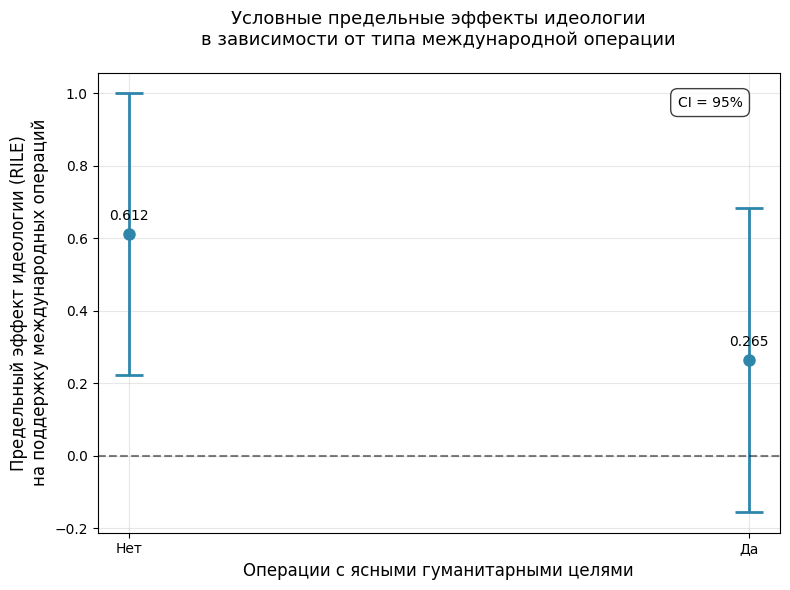

In [51]:
values = marpor.humanitarian.unique()
marg_effect = m11.params[1] + m11.params[12]*values
Cov_m3 = np.asmatrix(m11.cov_params())
se = (Cov_m3[1,1] + values**2*(Cov_m3[12,12]) + 2*values*Cov_m3[1,12])**(.5)

fig, ax = plt.subplots(figsize=(8, 6))

plt.errorbar(values, marg_effect, yerr=stats.norm.ppf(0.975)*se, 
             fmt='o', markersize=8, capsize=10, capthick=2,
             color='#2E86AB', linewidth=2)

ax.set(xticks=[0,1], 
       xticklabels=['Нет', 'Да'])
ax.set_ylabel('Предельный эффект идеологии (RILE)\nна поддержку международных операций', 
              fontsize=12)
ax.set_xlabel('Операции с ясными гуманитарными целями', fontsize=12)
ax.set_title('Условные предельные эффекты идеологии\nв зависимости от типа международной операции', 
             fontsize=13, pad=20)

ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)

for i, (x, y) in enumerate(zip(values, marg_effect)):
    ax.annotate(f'{y:.3f}', (x, y), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=10)
    
plt.annotate(text='CI = 95%', 
             xy=(0.85, 0.95), 
             xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.75),
             fontsize=10,
             verticalalignment='top')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(PROJECT_ROOT.joinpath('figures/fig12'))

**Условные предельные эффекты идеологии (Модель 3.4)**

На представленном графике визуализированы условные предельные эффекты идеологической позиции партии на вероятность поддержки международных военных операций, рассчитанные отдельно для операций с явными гуманитарными целями и для всех прочих (негуманитарных) операций, при фиксированных значениях контрольных переменных.

Для негуманитарных операций предельный эффект идеологии является положительным и статистически значимым. Точечная оценка эффекта расположена существенно выше нуля, а соответствующий 95% доверительный интервал полностью находится в положительной области, не включая нуль. Это указывает на устойчивую и надежную положительную связь: смещение партийной идеологии вправо последовательно ассоциируется с увеличением вероятности поддержки данного типа интервенций.

Для операций с ясными гуманитарными целями картина статистической надежности меняется. Хотя точечная оценка предельного эффекта также положительна, соответствующий 95% доверительный интервал пересекает нулевую линию. Это означает, что на принятом уровне уверенности положительный эффект идеологии для гуманитарных операций не является статистически значимым. Иными словами, в данных отсутствуют убедительные доказательства того, что правая идеология систематически повышает вероятность поддержки именно гуманитарных военных миссий.

График предельных эффектов обеспечивает наглядную интерпретацию результатов регрессионного анализа. Визуализация подтверждает, что выявленная в модели положительная связь идеологии с поддержкой применения силы существенно ослабевает и теряет статистическую надежность в контексте гуманитарных операций.

Таким образом, идеологический раскол в отношении к международным военным операциям проявляется в наиболее четкой и статистически устойчивой форме именно для негуманитарных операций. Что касается операций с ясными гуманитарными целями, то для них идеологическая диспозиция, по-видимому, играет менее определенную и статистически неуловимую роль, что может указывать на наличие иных, более значимых детерминант поддержки в данном контексте.

In [52]:
# модели, построенные на выборке без кейсов Германии и Италии

marpor_wo_ger_ita = marpor_wo_ger_ita.drop(columns={'rile2', 'rile_gov', 'rile2_gov'})

marpor_wo_ger_ita['rile_combat'] = marpor_wo_ger_ita['rile']*marpor_wo_ger_ita['combat']

y = marpor_wo_ger_ita['support']
X = marpor_wo_ger_ita.drop(columns=['support','cooperative','humanitarian','country'])
X = sm.add_constant(X)

m9_add = sm.GLM(y, X, family=sm.families.Binomial())
m9_add = m9_add.fit(cov_type='cluster',cov_kwds={'groups': marpor_wo_ger_ita['country']})

marpor_wo_ger_ita = marpor_wo_ger_ita.drop(columns={'rile_combat'})
marpor_wo_ger_ita['rile_cooperative'] = marpor_wo_ger_ita['rile']*marpor_wo_ger_ita['cooperative']

y = marpor_wo_ger_ita['support']
X = marpor_wo_ger_ita.drop(columns=['support','combat','humanitarian','country'])
X = sm.add_constant(X)

m10_add = sm.GLM(y, X, family=sm.families.Binomial())
m10_add = m10_add.fit(cov_type='cluster',cov_kwds={'groups': marpor_wo_ger_ita['country']})

marpor_wo_ger_ita = marpor_wo_ger_ita.drop(columns={'rile_cooperative'})
marpor_wo_ger_ita['rile_humanitarian'] = marpor_wo_ger_ita['rile']*marpor_wo_ger_ita['humanitarian']

y = marpor_wo_ger_ita['support']
X = marpor_wo_ger_ita.drop(columns=['support','combat','cooperative','country'])
X = sm.add_constant(X)

m11_add = sm.GLM(y, X, family=sm.families.Binomial())
m11_add = m11_add.fit(cov_type='cluster',cov_kwds={'groups': marpor_wo_ger_ita['country']})

In [53]:
# модели, построенные на выборке CHES

ches = ches.drop(columns={'lrgen2', 'lrgen_gov', 'lrgen2_gov'})

ches['lrgen_combat'] = ches['lrgen']*ches['combat']

y = ches['support']
X = ches.drop(columns=['support','cooperative','humanitarian','country'])
X = sm.add_constant(X)

m12 = sm.GLM(y, X, family=sm.families.Binomial())
m12 = m12.fit(cov_type='cluster',cov_kwds={'groups': ches['country']})

ches = ches.drop(columns={'lrgen_combat'})
ches['lrgen_cooperative'] = ches['lrgen']*ches['cooperative']

y = ches['support']
X = ches.drop(columns=['support','combat','humanitarian','country'])
X = sm.add_constant(X)

m13 = sm.GLM(y, X, family=sm.families.Binomial())
m13 = m13.fit(cov_type='cluster',cov_kwds={'groups': ches['country']})

ches = ches.drop(columns={'lrgen_cooperative'})
ches['lrgen_humanitarian'] = ches['lrgen']*ches['humanitarian']

y = ches['support']
X = ches.drop(columns=['support','combat','cooperative','country'])
X = sm.add_constant(X)

m14 = sm.GLM(y, X, family=sm.families.Binomial())
m14 = m14.fit(cov_type='cluster',cov_kwds={'groups': ches['country']})

In [54]:
t = summary_col(
        [m9, m10, m11, m9_add, m10_add, m11_add, m12, m13, m14],
        stars=True,
        model_names=['model 1', 'model 2', 'model 3', 
                     'model 4', 'model 5', 'model 6',
                     'model 7', 'model 8', 'model 9'],
        info_dict={
            'N': lambda x: '{0:d}'.format(int(x.nobs)),
            'LLF': lambda x: '{:.3f}'.format(x.llf),
            'Pseudo R2': lambda x: '{:.3f}'.format(1 - (x.llf / x.llnull)),
            'AIC': lambda x: '{:.1f}'.format(x.aic),
        },
        regressor_order=[
            'const',
            'rile',
            'lrgen',
            'gov',
            'wthdr',
            'alliance',
            'postcom',
            'pervote',
            'herf',
            'un',
            'nato',
            'eu',
            'combat',
            'rile_combat',
            'lrgen_combat',
            'cooperative',
            'rile_cooperative',
            'lrgen_cooperative',
            'humanitarian',
            'rile_humanitarian',
            'lrgen_humanitarian'
        ],
        float_format='%.3f'
    )

print(t)
print("""
All models include cluster-robust standard errors.
Models 1-6 are based on a MARPOR sample
Models 4-6 are based on a limited sample (without German and Italian parties) 
Models 7-9 are based on a CHES sample
""")


                    model 1   model 2   model 3   model 4   model 5   model 6   model 7   model 8   model 9 
------------------------------------------------------------------------------------------------------------
const              -2.914**  -1.956**  -3.385*** -2.172*   -1.459    -2.450**  -1.669    -1.501**  -1.801*  
                   (1.383)   (0.806)   (1.269)   (1.294)   (0.917)   (1.227)   (1.073)   (0.690)   (1.012)  
rile               0.540**   0.338**   0.612***  0.455**   0.285     0.496**                                
                   (0.218)   (0.134)   (0.198)   (0.225)   (0.200)   (0.244)                                
lrgen                                                                          0.298*    0.269*    0.310*   
                                                                               (0.154)   (0.154)   (0.175)  
gov                1.345*    1.349*    1.348*    0.791     0.777     0.793     1.061     1.065     1.050    
                  

In [55]:
with open(PROJECT_ROOT.joinpath('tables/t3.tex'), 'w') as f:
    f.write(t.as_latex())

with open(PROJECT_ROOT.joinpath('tables/t3.html'), 'w') as f:
    f.write(t.as_html())

Проведенный анализ устойчивости результатов регрессионного моделирования позволяет сформулировать следующие выводы. Положительная связь правой идеологической позиции партии с поддержкой участия в международных военных операциях является статистически значимой и демонстрирует высокую устойчивость к изменениям состава выборки и методам измерения ключевой независимой переменной.

В то же время, гипотезы о систематической модификации этого базового идеологического эффекта в зависимости от типа операции не находят надежного эмпирического подтверждения. Предположение о значимом влиянии высокоинтенсивного боевого характера операции последовательно опровергается во всех спецификациях моделей. Эффекты взаимодействия идеологии с кооперативным и гуманитарным характером операций, выявленные в базовых моделях, оказываются статистически неустойчивыми: их значимость существенно снижается или полностью исчезает при тестировании на альтернативных выборках и при использовании иного операционализации идеологии.

Таким образом, эмпирические данные указывают на то, что выявленная положительная связь между правой идеологией и поддержкой применения военной силы носит универсальный характер и не обнаруживает надежной систематической вариации в зависимости от конкретного контекста военной операции.

#### Байесовская статистика

In [56]:
trace = extract_inference_data(
    pd.read_csv(PROJECT_ROOT.joinpath('bmodels/converted/zoib_combat.csv'))
    )

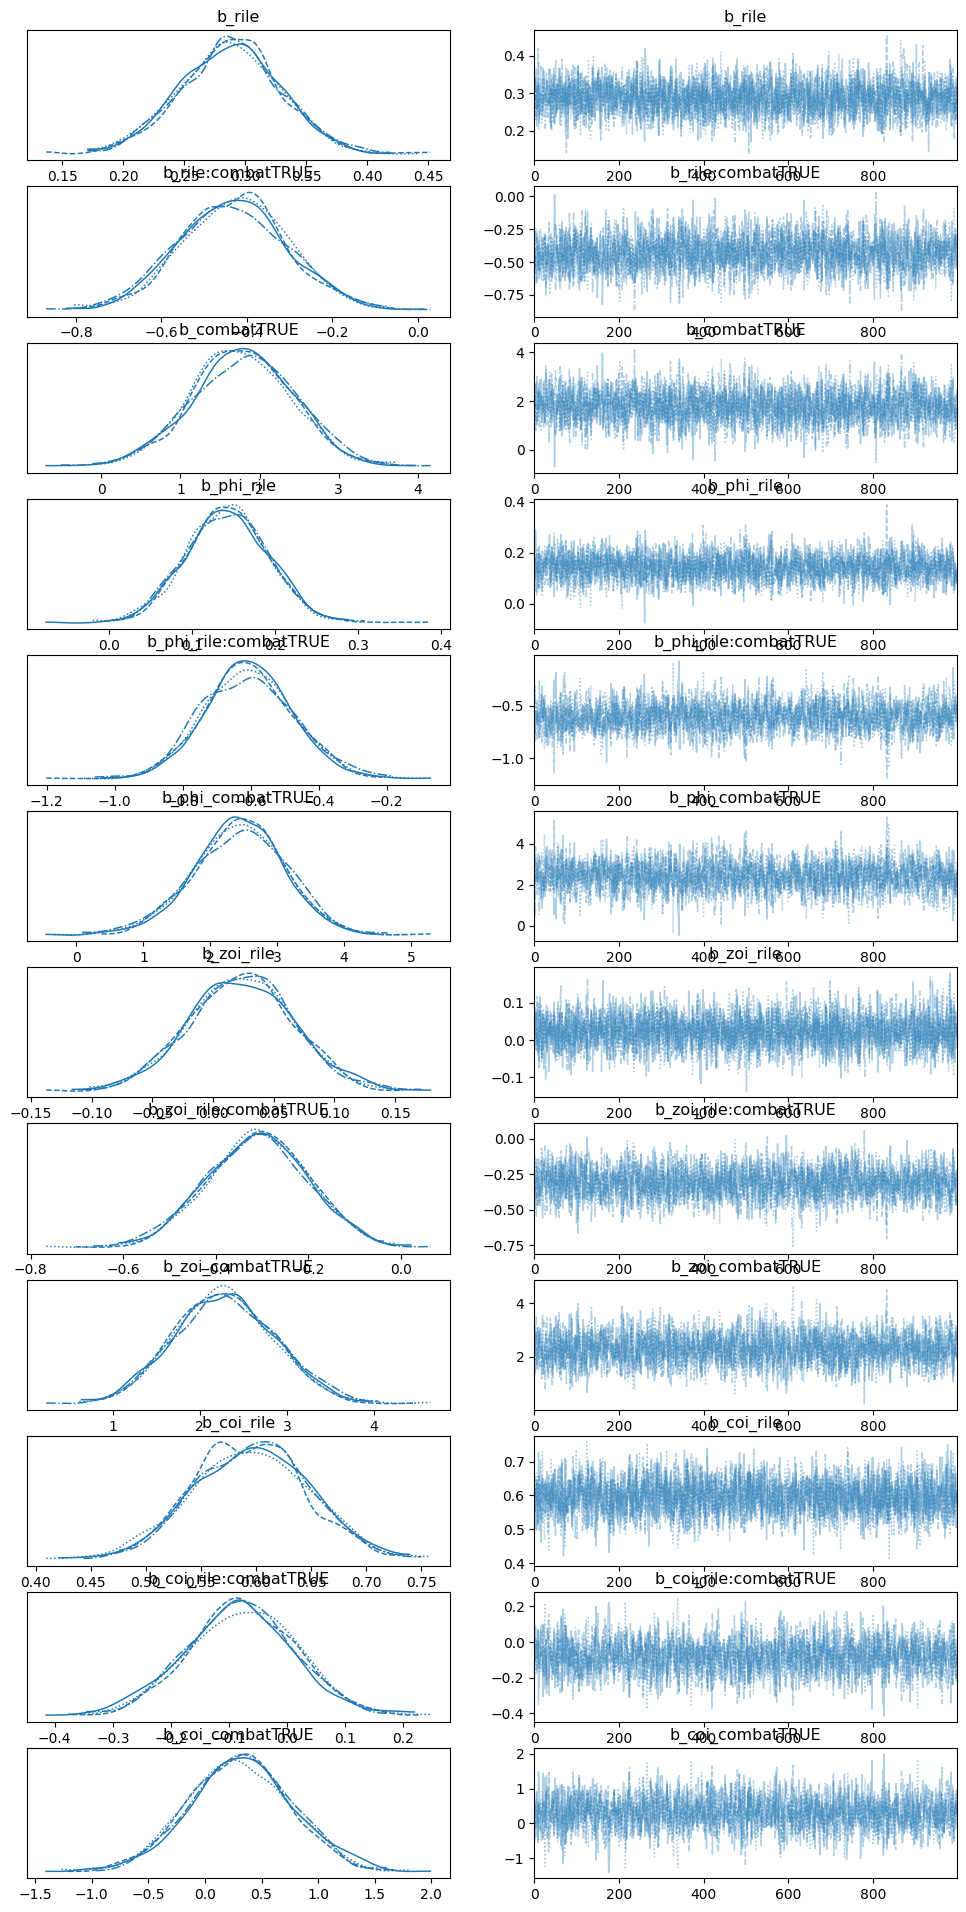

In [57]:
az.plot_trace(trace.posterior, 
              var_names=[
                'b_rile', 'b_rile:combatTRUE','b_combatTRUE',
                'b_phi_rile', 'b_phi_rile:combatTRUE','b_phi_combatTRUE',
                'b_zoi_rile', 'b_zoi_rile:combatTRUE','b_zoi_combatTRUE',
                'b_coi_rile', 'b_coi_rile:combatTRUE','b_coi_combatTRUE',
                  ],
              compact=True)

plt.savefig(PROJECT_ROOT.joinpath('figures/fig13'))

Диагностики позволяют нам проверить сходимость алгоритма. Одна из таких диагностик – trace plot, график, отображающий значения параметров на каждой итерации и позволяющий увидеть, как они изменяются со временем.

Распределение $\beta$ на графике слева похоже на нормальное, временной ряд для $\beta$ на графике справа – стационарный (постоянные, не зависящие от времени итерации). Это позволяет предположить, что алгоритм сошелся.

In [58]:
summary = az.summary(
    trace.posterior,
    var_names=[
        'b_rile', 'b_rile:combatTRUE','b_combatTRUE',
        'b_phi_rile', 'b_phi_rile:combatTRUE','b_phi_combatTRUE',
        'b_zoi_rile', 'b_zoi_rile:combatTRUE','b_zoi_combatTRUE',
        'b_coi_rile', 'b_coi_rile:combatTRUE','b_coi_combatTRUE',
        ]
)
summary

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
b_rile                 0.287  0.041   0.207    0.363      0.001    0.001   
b_rile:combatTRUE     -0.431  0.126  -0.659   -0.185      0.003    0.002   
b_combatTRUE           1.783  0.642   0.544    2.935      0.013    0.009   
b_phi_rile             0.142  0.049   0.052    0.232      0.001    0.001   
b_phi_rile:combatTRUE -0.605  0.133  -0.848   -0.352      0.003    0.002   
b_phi_combatTRUE       2.425  0.691   1.123    3.692      0.016    0.011   
b_zoi_rile             0.023  0.043  -0.057    0.104      0.001    0.001   
b_zoi_rile:combatTRUE -0.310  0.108  -0.509   -0.108      0.002    0.002   
b_zoi_combatTRUE       2.286  0.568   1.286    3.397      0.012    0.009   
b_coi_rile             0.596  0.052   0.500    0.691      0.001    0.001   
b_coi_rile:combatTRUE -0.079  0.093  -0.251    0.097      0.002    0.001   
b_coi_combatTRUE       0.309  0.455  -0.530    1.170      0.010    0.007   

                       ess_bulk  ess_tail  r_hat  
b_rile                   2937.0    2880.0    1.0  
b_rile:combatTRUE        2177.0    2754.0    1.0  
b_combatTRUE             2288.0    2890.0    1.0  
b_phi_rile               2587.0    3231.0    1.0  
b_phi_rile:combatTRUE    1813.0    2428.0    1.0  
b_phi_combatTRUE         1862.0    2382.0    1.0  
b_zoi_rile               3673.0    2947.0    1.0  
b_zoi_rile:combatTRUE    2255.0    2384.0    1.0  
b_zoi_combatTRUE         2285.0    2415.0    1.0  
b_coi_rile               2805.0    2878.0    1.0  
b_coi_rile:combatTRUE    1832.0    2560.0    1.0  
b_coi_combatTRUE         1889.0    2668.0    1.0

In [59]:
t = az.summary(trace.posterior)

with open(PROJECT_ROOT.joinpath('tables/t4.html'), 'w') as f:
    f.write(t.to_html())

/Users/solodov_ea/Desktop/проект/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


**Диагностика сходимости модели**
 
Для всех параметров модели значение $\hat{R}$ равно 1.0. Это указывает на отсутствие различий между цепями и свидетельствует о достижении стационарного распределения. В прикладной байесовской практике значения $\hat{R} < 1.01$ считаются признаком хорошей сходимости, таким образом, полученные результаты удовлетворяют строгим критериям конвергенции.

Показатели эффективного размера выборки как для основной части апостериорного распределения *(ess_bulk)*, так и для хвостов *(ess_tail)* во всех случаях превышают 1 800 и в ряде параметров достигают значений свыше 3 000. Это свидетельствует о низкой автокорреляции между последовательными выборками и высокой эффективности алгоритма NUTS. Достаточно высокие значения *ess_tail* особенно важны для корректной оценки достоверных интервалов.

Монте-Карло ошибки для апостериорных средних *(mcse_mean)* и стандартных отклонений *(mcse_sd)* малы по сравнению с соответствующими оценками параметров. Во всех случаях отношение MCSE к стандартному отклонению существенно ниже эмпирического порога в 0.1, что указывает на высокую точность численной аппроксимации апостериорных моментов.

Совокупность диагностических показателей указывает на хорошую сходимость модели и отсутствие численных проблем при оценивании. Ни для одного из параметров не наблюдается признаков плохого смешивания цепей, недостаточного числа эффективных наблюдений или нестабильности апостериорных оценок. Это позволяет считать полученные апостериорные распределения надёжной основой для последующей интерпретации коэффициентов и эконометрических выводов.

**Модель 1.4. Идеология и поддержка операций высокой интенсивности**

* Условное среднее бета-распределения ($\mu$-параметр)

Для операций, не относящихся к высокоинтенсивным боевым действиям, идеология оказывает устойчивое положительное влияние на средний уровень поддержки: смещение вправо по идеологическому спектру связано с ростом условного среднего зависимой переменной *($\beta$ = 0.287, 95% HDI: [0.207; 0.363])*. Этот результат полностью воспроизводит выводы FLR-модели и подтверждает наличие систематического идеологического градиента в отношении «менее рискованных» военных миссий.

Переменная взаимодействия между идеологией и боевым характером операции имеет отрицательный и статистически достоверный эффект *($\beta$ = −0.431, 95% HDI: [−0.659; −0.185])*. Это указывает на существенное ослабление положительного идеологического эффекта в контексте операций высокой интенсивности. В результате для боевых миссий предельный эффект идеологии заметно ниже и приближается к нулю, что согласуется с выводом FLR-модели о том, что наклон идеологического эффекта не усиливается в условиях повышенного риска.

Сам боевой характер операции оказывает положительное влияние на условное среднее поддержки *($\beta$ = 1.783, 95% HDI: [0.544; 2.935])*, указывая на то, что операции высокой интенсивности в целом получают более высокий уровень поддержки, независимо от идеологической позиции партии.

* Точность бета-распределения ($/phi$-параметр)

Компонента точности позволяет оценить, насколько однородны позиции партий вокруг условного среднего. Для небoевых операций идеология положительно и статистически достоверно влияет на параметр точности *($\beta$ = 0.142, 95% HDI: [0.052; 0.232])*, что указывает на более консолидированные позиции среди правых партий.

Однако взаимодействие с боевым характером операции имеет выраженный отрицательный эффект *($\beta$ = −0.605, 95% HDI: [−0.848; −0.352])*. Это означает, что в условиях высокоинтенсивных боевых миссий по мере смещения вправо по идеологическому спектру наблюдается рост гетерогенности позиций. Иначе говоря, именно среди правых партий боевые операции сопровождаются меньшей дисциплиной и большим разбросом оценок.

При этом сам факт боевой операции существенно повышает параметр точности *($\beta$ = 2.425, 95% HDI: [1.123; 3.692])*, что свидетельствует о более концентрированном распределении позиций в целом. Таким образом, боевые миссии одновременно повышают общий уровень консолидации, но делают идеологические различия менее предсказуемыми.

* Вероятность инфляции экстремальных исходов ($\alpha$-параметр)

Оценки компоненты инфляции экстремальных значений показывают, что для небoевых операций идеология не оказывает существенного влияния на вероятность достижения граничных значений *($\beta$ = 0.023, 95% HDI: [−0.057; 0.104])*. Это указывает на отсутствие систематической связи между идеологией и склонностью занимать полностью крайние позиции.

Однако взаимодействие с боевым характером операции имеет отрицательный и статистически достоверный эффект *($\beta$ = −0.310, 95% HDI: [−0.509; −0.108])*. Следовательно, для операций высокой интенсивности смещение вправо по идеологическому спектру связано со снижением вероятности экстремальных исходов. Более правые партии в таких условиях чаще избегают полностью полярных позиций, что может отражать стратегическую осторожность в контексте повышенных политических и репутационных издержек.

Сам боевой характер операции, напротив, резко увеличивает вероятность экстремальных значений *($\beta$ = 2.286, 95% HDI: [1.286; 3.397])*, указывая на то, что такие миссии в целом вызывают более поляризованные реакции.

* Вероятность инфляции единиц ($\gamma$-параметр)

Компонента инфляции единиц отражает факторы, связанные с вероятностью полной поддержки операции. Для небoевых миссий идеология оказывает сильное положительное влияние *($\beta$ = 0.596, 95% HDI: [0.500; 0.691])*, что свидетельствует о росте вероятности единичного исхода по мере смещения вправо.

Взаимодействие с боевым характером операции, однако, статистически недостоверно *($\beta$ = −0.079, 95% HDI: [−0.251; 0.097])*. Это означает, что влияние идеологии на вероятность полной поддержки не отличается систематически между боевыми и небoевыми миссиями. Аналогично, сам боевой характер операции не оказывает достоверного влияния на вероятность единичного исхода *($\beta$ = 0.309, 95% HDI: [−0.530; 1.170])*.

В совокупности результаты ZOIB-модели согласуются с выводами FLR-модели 1.4 о том, что положительная связь правой идеологии с поддержкой применения силы не усиливается в контексте высокоинтенсивных боевых операций. Однако ZOIB-подход позволяет уточнить данный вывод: ослабление идеологического эффекта проявляется прежде всего на уровне условного среднего и структуры вариативности, тогда как вероятность полной поддержки остается относительно стабильной.

Таким образом, характер операции модифицирует не столько сам факт идеологической диспозиции, сколько форму и консистентность её проявления. Для операций высокой интенсивности идеологические различия оказываются менее выраженными и более фрагментированными, что указывает на контекстную условность партийных позиций в условиях повышенного риска и неопределенности.


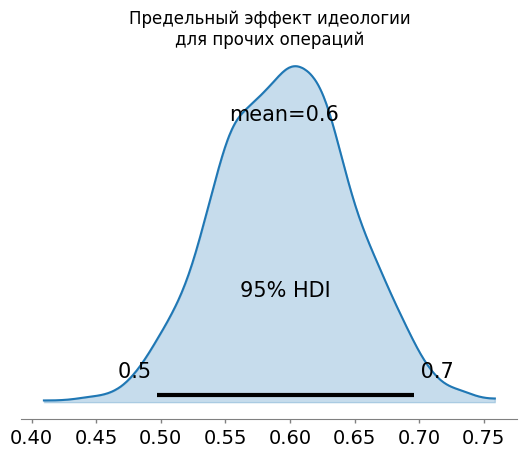

In [60]:
az.plot_posterior(
    trace.posterior,
    var_names=['b_coi_rile'],
    hdi_prob=0.95, 
    #ref_val=0,
    fill_alpha=0.25, 
    #ref_val_color='black'
    )
plt.title('Предельный эффект идеологии\nдля прочих операций');
plt.savefig(PROJECT_ROOT.joinpath('figures/fig14'))

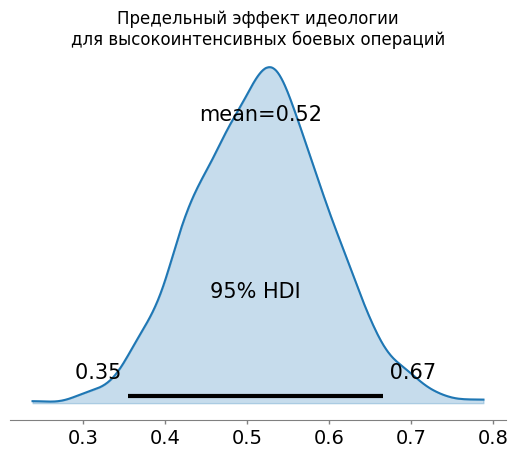

In [61]:
diff = trace.posterior['b_coi_rile'] + trace.posterior['b_coi_rile:combatTRUE']

az.plot_posterior(
    diff,
    hdi_prob=0.95, 
    #ref_val=0,
    fill_alpha=0.25, 
    #ref_val_color='black'
    )
plt.title('Предельный эффект идеологии\nдля высокоинтенсивных боевых операций');
plt.savefig(PROJECT_ROOT.joinpath('figures/fig15'))

In [62]:
trace = extract_inference_data(
    pd.read_csv(PROJECT_ROOT.joinpath('bmodels/converted/zoib_cooperative.csv'))
    )

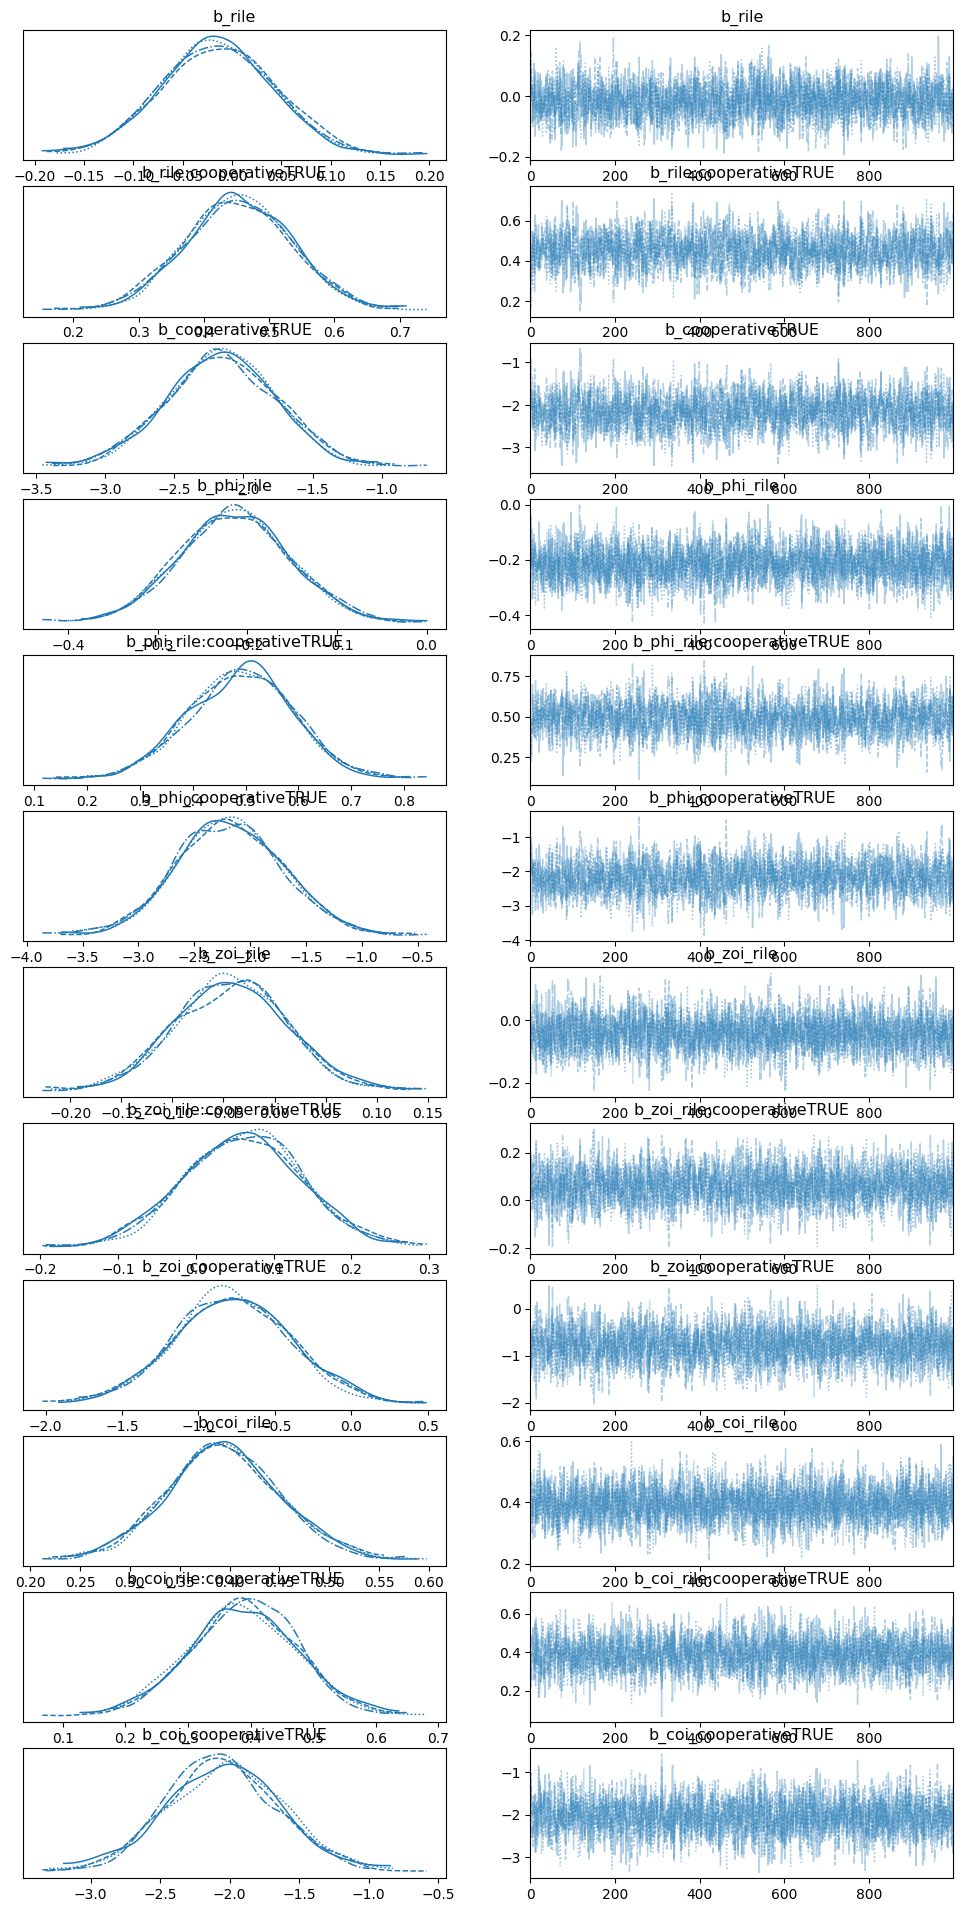

In [63]:
az.plot_trace(trace.posterior, 
              var_names=[
                'b_rile', 'b_rile:cooperativeTRUE','b_cooperativeTRUE',
                'b_phi_rile', 'b_phi_rile:cooperativeTRUE','b_phi_cooperativeTRUE',
                'b_zoi_rile', 'b_zoi_rile:cooperativeTRUE','b_zoi_cooperativeTRUE',
                'b_coi_rile', 'b_coi_rile:cooperativeTRUE','b_coi_cooperativeTRUE'
                  ],
              compact=True)

plt.savefig(PROJECT_ROOT.joinpath('figures/fig16'))

Диагностики позволяют нам проверить сходимость алгоритма. Одна из таких диагностик – trace plot, график, отображающий значения параметров на каждой итерации и позволяющий увидеть, как они изменяются со временем.

Распределение $\beta$ на графике слева похоже на нормальное, временной ряд для $\beta$ на графике справа – стационарный (постоянные, не зависящие от времени итерации). Это позволяет предположить, что алгоритм сошелся.

In [64]:
summary = az.summary(
    trace.posterior,
    var_names=[
        'b_rile', 'b_rile:cooperativeTRUE','b_cooperativeTRUE',
        'b_phi_rile', 'b_phi_rile:cooperativeTRUE','b_phi_cooperativeTRUE',
        'b_zoi_rile', 'b_zoi_rile:cooperativeTRUE','b_zoi_cooperativeTRUE',
        'b_coi_rile', 'b_coi_rile:cooperativeTRUE','b_coi_cooperativeTRUE'
        ]
)
summary

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
b_rile                     -0.015  0.056  -0.116    0.091      0.001    0.001   
b_rile:cooperativeTRUE      0.453  0.082   0.310    0.612      0.002    0.001   
b_cooperativeTRUE          -2.159  0.394  -2.897   -1.440      0.009    0.006   
b_phi_rile                 -0.214  0.062  -0.324   -0.095      0.001    0.001   
b_phi_rile:cooperativeTRUE  0.492  0.099   0.303    0.672      0.002    0.002   
b_phi_cooperativeTRUE      -2.183  0.471  -3.067   -1.298      0.012    0.008   
b_zoi_rile                 -0.042  0.055  -0.152    0.055      0.001    0.001   
b_zoi_rile:cooperativeTRUE  0.061  0.076  -0.085    0.201      0.002    0.001   
b_zoi_cooperativeTRUE      -0.776  0.377  -1.451   -0.023      0.008    0.006   
b_coi_rile                  0.394  0.056   0.288    0.502      0.001    0.001   
b_coi_rile:cooperativeTRUE  0.388  0.086   0.226    0.545      0.002    0.001   
b_coi_cooperativeTRUE      -2.048  0.411  -2.836   -1.270      0.008    0.006   

                            ess_bulk  ess_tail  r_hat  
b_rile                        2271.0    2965.0    1.0  
b_rile:cooperativeTRUE        1780.0    2400.0    1.0  
b_cooperativeTRUE             1776.0    2406.0    1.0  
b_phi_rile                    2351.0    2837.0    1.0  
b_phi_rile:cooperativeTRUE    1688.0    2266.0    1.0  
b_phi_cooperativeTRUE         1652.0    2109.0    1.0  
b_zoi_rile                    2797.0    3014.0    1.0  
b_zoi_rile:cooperativeTRUE    2220.0    2534.0    1.0  
b_zoi_cooperativeTRUE         2248.0    2445.0    1.0  
b_coi_rile                    3194.0    2996.0    1.0  
b_coi_rile:cooperativeTRUE    2635.0    3004.0    1.0  
b_coi_cooperativeTRUE         2555.0    2387.0    1.0

In [65]:
t = az.summary(trace.posterior)

with open(PROJECT_ROOT.joinpath('tables/t5.html'), 'w') as f:
    f.write(t.to_html())

/Users/solodov_ea/Desktop/проект/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


**Диагностика сходимости модели**
 
Для всех параметров модели значение $\hat{R}$ равно 1.0. Это указывает на отсутствие различий между цепями и свидетельствует о достижении стационарного распределения. В прикладной байесовской практике значения $\hat{R} < 1.01$ считаются признаком хорошей сходимости, таким образом, полученные результаты удовлетворяют строгим критериям конвергенции.

Показатели эффективного размера выборки как для основной части апостериорного распределения *(ess_bulk)*, так и для хвостов *(ess_tail)* во всех случаях превышают 1 600 и в ряде параметров достигают значений свыше 3 000. Это свидетельствует о низкой автокорреляции между последовательными выборками и высокой эффективности алгоритма NUTS. Достаточно высокие значения *ess_tail* особенно важны для корректной оценки достоверных интервалов.

Монте-Карло ошибки для апостериорных средних *(mcse_mean)* и стандартных отклонений *(mcse_sd)* малы по сравнению с соответствующими оценками параметров. Во всех случаях отношение MCSE к стандартному отклонению существенно ниже эмпирического порога в 0.1, что указывает на высокую точность численной аппроксимации апостериорных моментов.

Совокупность диагностических показателей указывает на хорошую сходимость модели и отсутствие численных проблем при оценивании. Ни для одного из параметров не наблюдается признаков плохого смешивания цепей, недостаточного числа эффективных наблюдений или нестабильности апостериорных оценок. Это позволяет считать полученные апостериорные распределения надёжной основой для последующей интерпретации коэффициентов и эконометрических выводов.

**Модель 2.4. Идеология и поддержка операций кооперативного характера**

* Условное среднее бета-распределения ($\mu$-параметр)

Для операций, не относящихся к кооперативным, идеология не оказывает заметного влияния на условное среднее поддержки: соответствующий коэффициент близок к нулю и статистически недостоверен *($\beta$ = −0.015, 95% HDI: [−0.116; 0.091])*. Это указывает на отсутствие устойчивого идеологического градиента в отношении некооперативных миссий.

Переменная взаимодействия между идеологией и кооперативным характером операции имеет положительный и статистически достоверный эффект *($\beta$ = 0.453, 95% HDI: [0.310; 0.612])*. Следовательно, именно в контексте кооперативных операций идеологическая позиция партии приобретает значение: смещение вправо по идеологическому спектру связано с заметным ростом среднего уровня поддержки. Таким образом, совокупный идеологический эффект для кооперативных миссий является положительным и существенно превосходит эффект для некооперативных операций, что полностью согласуется с выводами FLR-модели 2.4.

При этом сам кооперативный характер операции оказывает сильное отрицательное влияние на условное среднее поддержки *($\beta$ = −2.159, 95% HDI: [−2.897; −1.440])*. Это означает, что для партий с крайне левой идеологической позицией кооперативные миссии в среднем получают значительно меньшую поддержку, чем некооперативные, формируя тем самым пересекающийся эффект взаимодействия.

* Точность бета-распределения ($\phi$-параметр)

Параметры компоненты точности показывают, насколько однородны позиции партий вокруг условного среднего. Для некооперативных операций смещение вправо по идеологическому спектру связано со снижением параметра точности *($\beta$ = −0.214, 95% HDI: [−0.324; −0.095])*, что указывает на рост вариативности позиций среди правых партий.

Однако взаимодействие идеологии с кооперативным характером операции имеет положительный и статистически достоверный эффект *($\beta$ = 0.492, 95% HDI: [0.303; 0.672])*. Это означает, что в контексте кооперативных миссий идеологическое смещение вправо, напротив, сопровождается ростом однородности и дисциплины партийных позиций.

Сам кооперативный характер операции существенно снижает параметр точности *($\beta$ = −2.183, 95% HDI: [−3.067; −1.298])*, что указывает на в целом более гетерогенное распределение позиций по таким миссиям. Таким образом, кооперативные операции сопровождаются большей неопределенностью, однако именно правые партии демонстрируют в них более согласованные позиции.

* Вероятность инфляции экстремальных исходов ($\alpha$-параметр)

Компонента инфляции экстремальных значений показывает, склонны ли партии занимать полностью крайние позиции (то есть демонстрировать полную поддержку или полное неприятие). Для некооперативных операций идеология не оказывает значимого влияния на вероятность экстремальных исходов *($\beta$ = −0.042, 95% HDI: [−0.152; 0.055])*. Аналогично, эффект взаимодействия также статистически недостоверен *($\beta$ = 0.061, 95% HDI: [−0.085; 0.201])*, что указывает на отсутствие систематической модерации данного механизма кооперативным контекстом.

В то же время сам кооперативный характер операции существенно снижает вероятность экстремальных значений *($\beta$ = −0.776, 95% HDI: [−1.451; −0.023])*. Это означает, что кооперативные миссии в целом реже вызывают полностью поляризованные реакции, что согласуется с их менее конфронтационной природой.

* Вероятность инфляции единиц ($\gamma$-параметр)

Оценки компоненты инфляции единиц отражают факторы, связанные с вероятностью полной поддержки операции. Для некооперативных миссий идеология оказывает устойчивое положительное влияние *($\beta$ = 0.394, 95% HDI: [0.288; 0.502])*, что указывает на рост вероятности единичного исхода по мере смещения вправо.

Взаимодействие с кооперативным характером операции также является положительным и статистически достоверным *($\beta$ = 0.388, 95% HDI: [0.226; 0.545])*. Следовательно, для кооперативных миссий идеологический эффект на вероятность полной поддержки существенно усиливается. Это означает, что правые партии не только в среднем более благосклонно относятся к кооперативным операциям, но и значительно чаще демонстрируют полностью консолидированную поддержку.

Сам кооперативный характер операции, однако, резко снижает вероятность единичного исхода *($\beta$ = −2.048, 95% HDI: [−2.836; −1.270])*, что вновь указывает на пересекающийся характер эффекта: левые партии существенно менее склонны полностью поддерживать кооперативные миссии, тогда как правые — напротив.

В целом результаты ZOIB-модели подтверждают выводы FLR-модели 2.4 о том, что идеологический эффект является существенно более сильным в контексте кооперативных операций. Однако ZOIB-подход позволяет уточнить данный результат, показав, что усиление идеологического градиента проявляется не только на уровне среднего уровня поддержки, но и в структуре распределения позиций. Для кооперативных миссий правые партии демонстрируют более высокую степень консолидации и более высокую вероятность полной поддержки, тогда как левые партии — более низкий уровень поддержки и большую гетерогенность позиций.

Таким образом, кооперативный характер операции выступает не просто контекстным модератором, а ключевым фактором, трансформирующим как интенсивность, так и форму идеологического влияния на поддержку применения военной силы.


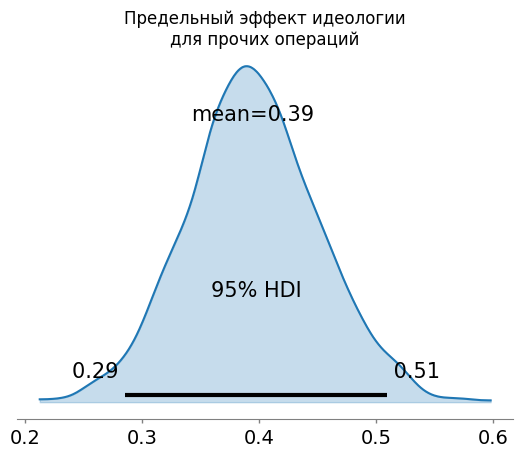

In [66]:
az.plot_posterior(
    trace.posterior,
    var_names=['b_coi_rile'],
    hdi_prob=0.95, 
    #ref_val=0,
    fill_alpha=0.25, 
    #ref_val_color='black'
    )
plt.title('Предельный эффект идеологии\nдля прочих операций');
plt.savefig(PROJECT_ROOT.joinpath('figures/fig17'))

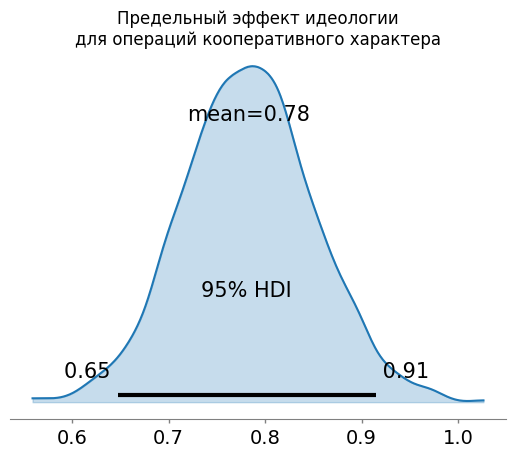

In [67]:
diff = trace.posterior['b_coi_rile'] + trace.posterior['b_coi_rile:cooperativeTRUE']

az.plot_posterior(
    diff,
    hdi_prob=0.95, 
    #ref_val=0,
    fill_alpha=0.25, 
    #ref_val_color='black'
    )
plt.title('Предельный эффект идеологии\nдля операций кооперативного характера');
plt.savefig(PROJECT_ROOT.joinpath('figures/fig18'))

In [68]:
trace = extract_inference_data(
    pd.read_csv(PROJECT_ROOT.joinpath('bmodels/converted/zoib_humanitarian.csv'))
    )

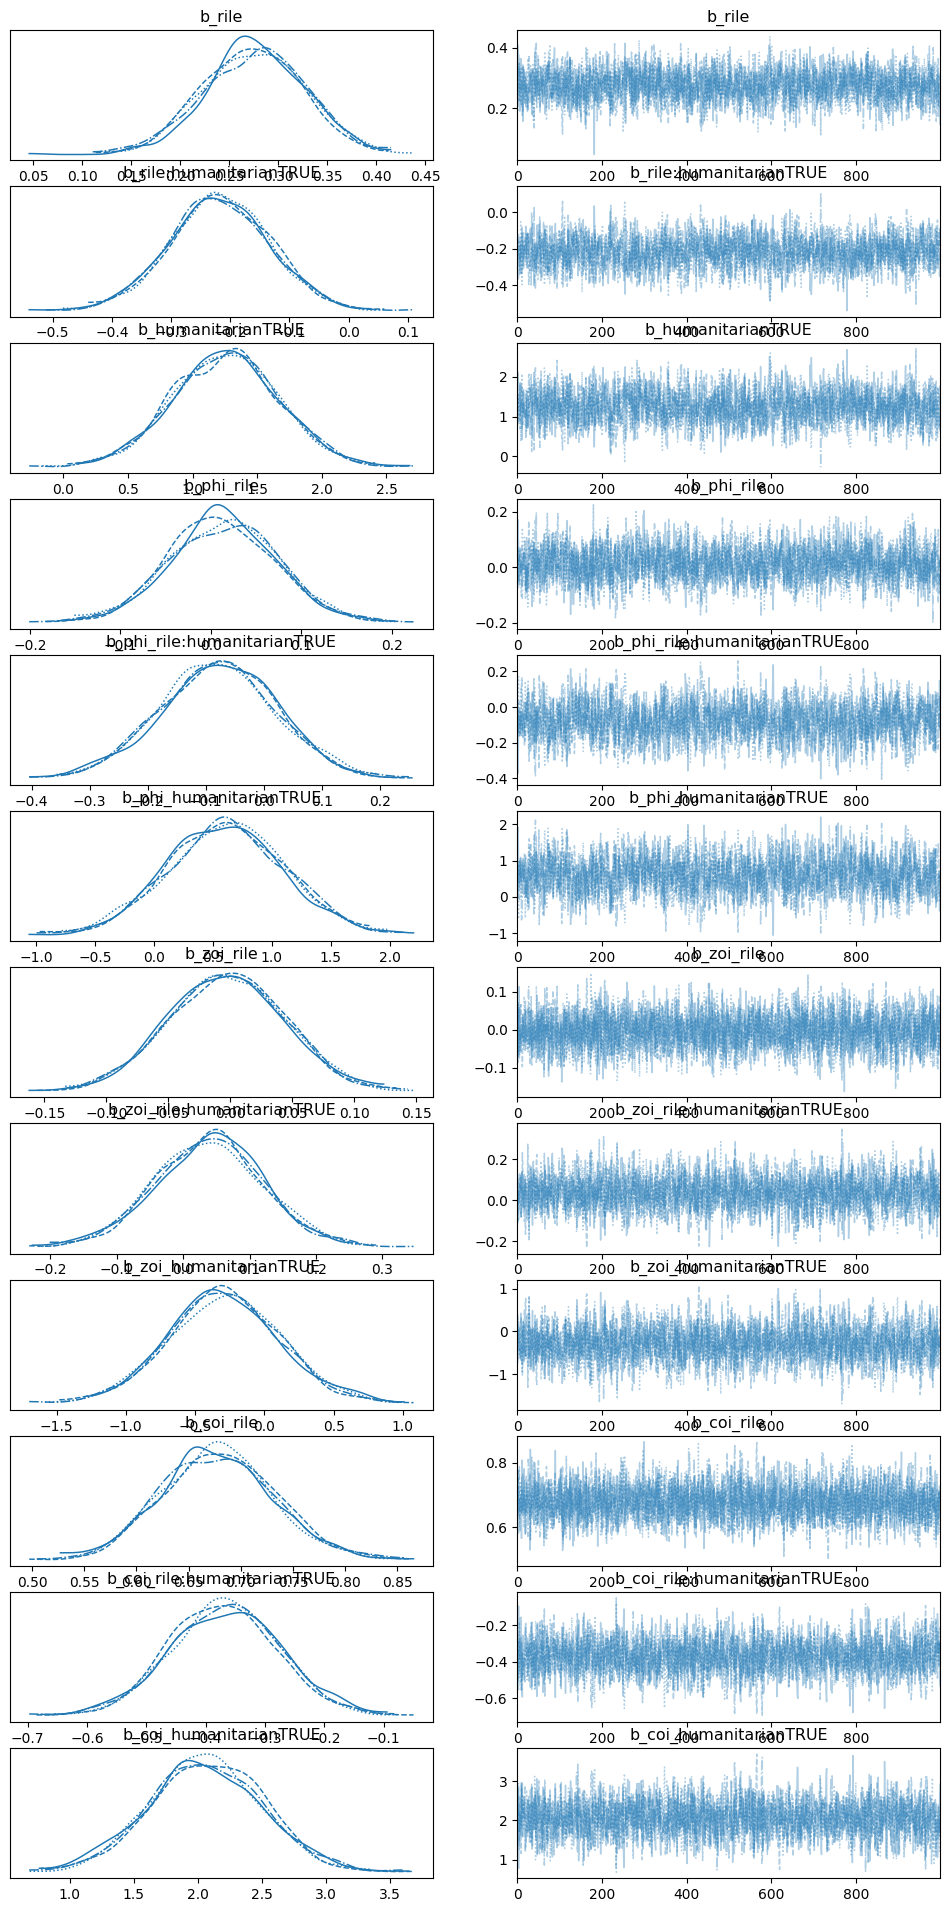

In [69]:
az.plot_trace(trace.posterior, 
              var_names=[
                'b_rile', 'b_rile:humanitarianTRUE','b_humanitarianTRUE',
                'b_phi_rile', 'b_phi_rile:humanitarianTRUE','b_phi_humanitarianTRUE',
                'b_zoi_rile', 'b_zoi_rile:humanitarianTRUE','b_zoi_humanitarianTRUE',
                'b_coi_rile', 'b_coi_rile:humanitarianTRUE','b_coi_humanitarianTRUE',
                  ],
              compact=True)

plt.savefig(PROJECT_ROOT.joinpath('figures/fig19'))

Диагностики позволяют нам проверить сходимость алгоритма. Одна из таких диагностик – trace plot, график, отображающий значения параметров на каждой итерации и позволяющий увидеть, как они изменяются со временем.

Распределение $\beta$ на графике слева похоже на нормальное, временной ряд для $\beta$ на графике справа – стационарный (постоянные, не зависящие от времени итерации). Это позволяет предположить, что алгоритм сошелся.

In [70]:
summary = az.summary(
    trace.posterior,
    var_names=[
        'b_rile', 'b_rile:humanitarianTRUE','b_humanitarianTRUE',
        'b_phi_rile', 'b_phi_rile:humanitarianTRUE','b_phi_humanitarianTRUE',
        'b_zoi_rile', 'b_zoi_rile:humanitarianTRUE','b_zoi_humanitarianTRUE',
        'b_coi_rile', 'b_coi_rile:humanitarianTRUE','b_coi_humanitarianTRUE',
        ]
)
summary

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
b_rile                       0.275  0.051   0.182    0.370      0.001   
b_rile:humanitarianTRUE     -0.218  0.083  -0.369   -0.054      0.002   
b_humanitarianTRUE           1.256  0.405   0.506    2.032      0.010   
b_phi_rile                   0.013  0.060  -0.098    0.127      0.001   
b_phi_rile:humanitarianTRUE -0.078  0.100  -0.260    0.117      0.003   
b_phi_humanitarianTRUE       0.612  0.493  -0.278    1.560      0.013   
b_zoi_rile                  -0.003  0.046  -0.094    0.080      0.001   
b_zoi_rile:humanitarianTRUE  0.039  0.081  -0.116    0.195      0.002   
b_zoi_humanitarianTRUE      -0.288  0.402  -1.061    0.474      0.008   
b_coi_rile                   0.678  0.053   0.575    0.775      0.001   
b_coi_rile:humanitarianTRUE -0.368  0.092  -0.540   -0.192      0.002   
b_coi_humanitarianTRUE       2.063  0.438   1.204    2.845      0.008   

                             mcse_sd  ess_bulk  ess_tail  r_hat  
b_rile                         0.001    1878.0    2365.0    1.0  
b_rile:humanitarianTRUE        0.001    1607.0    2231.0    1.0  
b_humanitarianTRUE             0.006    1631.0    2409.0    1.0  
b_phi_rile                     0.001    1707.0    2562.0    1.0  
b_phi_rile:humanitarianTRUE    0.001    1532.0    2392.0    1.0  
b_phi_humanitarianTRUE         0.007    1480.0    1994.0    1.0  
b_zoi_rile                     0.001    3151.0    3060.0    1.0  
b_zoi_rile:humanitarianTRUE    0.001    2369.0    2731.0    1.0  
b_zoi_humanitarianTRUE         0.006    2267.0    2534.0    1.0  
b_coi_rile                     0.001    3531.0    3131.0    1.0  
b_coi_rile:humanitarianTRUE    0.001    2721.0    2547.0    1.0  
b_coi_humanitarianTRUE         0.006    2765.0    2760.0    1.0

In [71]:
t = az.summary(trace.posterior)

with open(PROJECT_ROOT.joinpath('tables/t6.html'), 'w') as f:
    f.write(t.to_html())

/Users/solodov_ea/Desktop/проект/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


**Диагностика сходимости модели**
 
Для всех параметров модели значение $\hat{R}$ равно 1.0. Это указывает на отсутствие различий между цепями и свидетельствует о достижении стационарного распределения. В прикладной байесовской практике значения $\hat{R} < 1.01$ считаются признаком хорошей сходимости, таким образом, полученные результаты удовлетворяют строгим критериям конвергенции.

Показатели эффективного размера выборки как для основной части апостериорного распределения *(ess_bulk)*, так и для хвостов *(ess_tail)* во всех случаях превышают 1 800 и в ряде параметров достигают значений свыше 3 000. Это свидетельствует о низкой автокорреляции между последовательными выборками и высокой эффективности алгоритма NUTS. Достаточно высокие значения *ess_tail* особенно важны для корректной оценки достоверных интервалов.

Монте-Карло ошибки для апостериорных средних *(mcse_mean)* и стандартных отклонений *(mcse_sd)* малы по сравнению с соответствующими оценками параметров. Во всех случаях отношение MCSE к стандартному отклонению существенно ниже эмпирического порога в 0.1, что указывает на высокую точность численной аппроксимации апостериорных моментов.

Совокупность диагностических показателей указывает на хорошую сходимость модели и отсутствие численных проблем при оценивании. Ни для одного из параметров не наблюдается признаков плохого смешивания цепей, недостаточного числа эффективных наблюдений или нестабильности апостериорных оценок. Это позволяет считать полученные апостериорные распределения надёжной основой для последующей интерпретации коэффициентов и эконометрических выводов.

**Модель 3.4. Идеология и поддержка гуманитарных операций**

* Условное среднее бета-распределения ($\mu$-параметр)

Для операций, не относящихся к гуманитарным, идеологический эффект является положительным и статистически достоверным *($\beta$ = 0.275, 95% HDI: [0.182; 0.370])*. Это подтверждает устойчивую закономерность: смещение вправо по идеологическому спектру связано с ростом среднего уровня поддержки применения военной силы в «традиционном» контексте.

Коэффициент при переменной взаимодействия между идеологией и гуманитарным характером операции имеет отрицательный и статистически достоверный эффект *($\beta$ = −0.218, 95% HDI: [−0.369; −0.054])*. Это указывает на систематическое ослабление идеологического градиента в гуманитарных миссиях. Совокупный идеологический эффект для таких операций составляет приблизительно *0.275 − 0.218 = 0.057* и, таким образом, оказывается существенно слабее и близок к нулю. Иными словами, различия между левыми и правыми партиями в среднем уровне поддержки гуманитарных операций практически нивелируются.

При этом сам гуманитарный характер операции оказывает выраженное положительное влияние на условное среднее поддержки *($\beta$ = 1.256, 95% HDI: [0.506; 2.032])*. Это означает, что гуманитарные миссии в целом получают более высокую поддержку независимо от идеологической позиции партии, что принципиально отличает их от других типов операций.

* Точность бета-распределения ($\phi$-параметр)

Параметры компоненты точности не демонстрируют выраженных и устойчивых эффектов. Для негуманитарных операций идеология не связана с изменением вариативности позиций *($\beta$ = 0.013, 95% HDI: [−0.098; 0.127])*. Аналогично, взаимодействие идеологии с гуманитарным характером операции не достигает статистической достоверности *($\beta$ = −0.078, 95% HDI: [−0.260; 0.117])*.

Эффект самой переменной *humanitarian* также остается статистически неопределенным *($\beta$ = 0.612, 95% HDI: [−0.278; 1.560])*. В совокупности это указывает на то, что гуманитарный контекст не приводит к систематическим изменениям в степени однородности или разброса партийных позиций: различия между партиями проявляются преимущественно на уровне среднего уровня поддержки, а не в структуре вариативности.

* Вероятность инфляции экстремальных исходов ($\alpha$-параметр)

Компонента инфляции экстремальных значений не выявляет существенных эффектов. Идеология не связана с вероятностью крайних позиций для негуманитарных операций *($\beta$ = −0.003, 95% HDI: [−0.094; 0.080])*, а эффект взаимодействия также статистически недостоверен ($\beta$ = 0.039, 95% HDI: [−0.116; 0.195]).

Сам гуманитарный характер операции не оказывает устойчивого влияния на вероятность экстремальных исходов *($\beta$ = −0.288, 95% HDI: [−1.061; 0.474])*. Это означает, что гуманитарные миссии не сопровождаются систематическим ростом или снижением поляризации позиций партий; их отличительная особенность заключается не в крайности реакций, а в общем уровне поддержки.

* Вероятность инфляции единиц ($\gamma$-параметр)

Наиболее выраженные эффекты проявляются в компоненте инфляции единиц, отражающей вероятность полной поддержки операции. Для негуманитарных миссий идеология оказывает сильное положительное влияние *($\beta$ = 0.678, 95% HDI: [0.575; 0.775])*, что указывает на резкий рост вероятности единичного исхода по мере смещения вправо по идеологическому спектру.
Однако взаимодействие с гуманитарным характером операции имеет отрицательный и статистически достоверный эффект *($\beta$ = −0.368, 95% HDI: [−0.540; −0.192])*. Следовательно, для гуманитарных миссий идеологический эффект на вероятность полной поддержки существенно ослабевает. Это означает, что правые партии в меньшей степени отличаются от левых по склонности к полностью консолидированной поддержке именно гуманитарных операций.

При этом сам гуманитарный характер операции резко повышает вероятность единичного исхода *($\beta$ = 2.063, 95% HDI: [1.204; 2.845])*. Таким образом, гуманитарные миссии в целом значительно чаще получают полную поддержку, независимо от идеологической ориентации партии.

В целом результаты ZOIB-модели полностью согласуются с выводами FLR-модели 3.4 о том, что гуманитарный характер операции сглаживает идеологический раскол в поддержке применения военной силы. Однако ZOIB-подход позволяет уточнить механизм этого сглаживания. Ослабление идеологического эффекта проявляется как на уровне условного среднего, так и — особенно отчетливо — на уровне вероятности полной поддержки. При этом гуманитарные операции характеризуются в целом более высоким уровнем поддержки, но не сопровождаются ростом поляризации или изменением степени внутригрупповой однородности.

Таким образом, гуманитарный контекст трансформирует логику идеологического конфликта: поддержка таких операций носит более универсальный характер и в меньшей степени структурируется по линии «левые–правые». В отличие от кооперативных миссий, где правые партии демонстрируют усиленную и более консолидированную поддержку, гуманитарные операции выступают как деполитизированный тип применения силы, снижающий значимость идеологических различий.

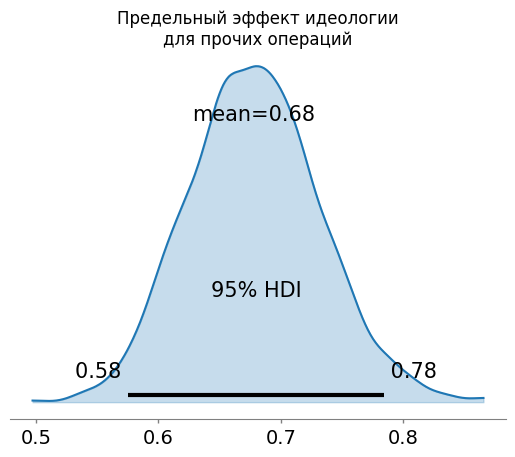

In [72]:
az.plot_posterior(
    trace.posterior,
    var_names=['b_coi_rile'],
    hdi_prob=0.95, 
    #ref_val=0,
    fill_alpha=0.25, 
    #ref_val_color='black'
    )
plt.title('Предельный эффект идеологии\nдля прочих операций');
plt.savefig(PROJECT_ROOT.joinpath('figures/fig20'))

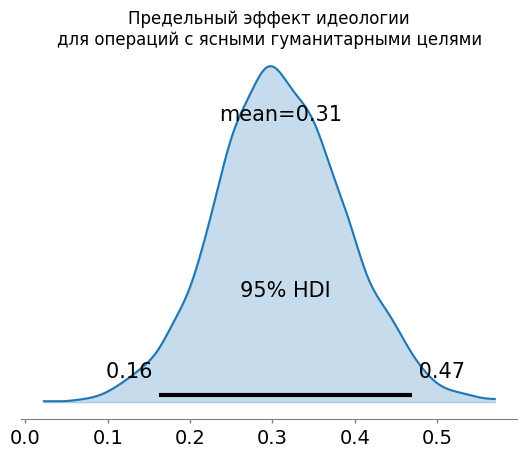

In [73]:
diff = trace.posterior['b_coi_rile'] + trace.posterior['b_coi_rile:humanitarianTRUE']

az.plot_posterior(
    diff,
    hdi_prob=0.95, 
    #ref_val=0,
    fill_alpha=0.25, 
    #ref_val_color='black'
    )
plt.title('Предельный эффект идеологии\nдля операций с ясными гуманитарными целями');
plt.savefig(PROJECT_ROOT.joinpath('figures/fig21'))